# 🧠 Training Gemma 2 2B to Reason: SFT → DPO → GRPO Pipeline

## Google Tunix Hackathon Submission

**Author:** Sandeep & Matthew

**Model:** Gemma 2 2B Instruct  

**Framework:** [Tunix](https://github.com/google/tunix/) - Google's JAX-native library for LLM post-training  

**Hardware:** Kaggle TPU v5e-8

---

## 📋 Overall Training and Evaluation Strategy

### Approach

This notebook implements a **three-stage post-training pipeline** to teach Gemma 2 2B to "show its work" - generating structured reasoning traces before providing answers. The goal is to produce outputs in the format:

```xml
<reasoning>step-by-step thought process</reasoning>
<answer>final answer</answer>
```

### Training Pipeline

| Stage | Method | Purpose | Epochs |
|-------|--------|---------|--------|
| **Stage 1** | Supervised Fine-Tuning (SFT) | Teach the model the output format and reasoning style | 3 |
| **Stage 2** | Direct Preference Optimization (DPO) | Refine preferences between good and bad reasoning | 1 |
| **Stage 3** | Group Relative Policy Optimization (GRPO) | Reinforce correct answers with reward signals | 1 |

### Compute Allocation (9-hour TPU Session)

| Stage | Time | Size (trained records) |
|-------|------|-------|
| SFT | 22 mins | ~3000 |
| DPO | 16 mins | ~5800 |
| GRPO (Math) | 56 mins | ~4500 |
| GRPO (Extra) | 43 mins | ~2500 |

### Key Techniques

- **LoRA (Low-Rank Adaptation):** We use rank-64 LoRA adapters targeting attention layers (Q, KV, attention output) and MLP layers (gate, up, down projections). This enables efficient fine-tuning while preserving base model knowledge.

- **Mesh Configuration:** For SFT/DPO we used [(8, 1), ("fsdp", "tp")] mesh configuration because these algorithms are dominated by forward/backward training compute, so 8-way FSDP maximizes memory savings and throughput and lets us reach an effective batch size of 32 via gradient accumulation for smoother, less noisy updates. With little reliance on long autoregressive rollouts, the extra sharding/communication overhead is amortized well, making (8,1) the best fit. For GRPO we used [(1, 4), ("fsdp", "tp")] mesh configuration because GRPO is rollout- and decode-heavy (plus often involves reference/KL computations), where tensor parallelism improves per-token generation efficiency and reduces per-chip KV-cache pressure for micro_batch=4 and num_generations=4. Using 4-way TP also makes it practical to split an 8-chip TPU between policy and reference workloads (or otherwise avoid rollout-time memory spikes), which is why (1,4) is the better match for GRPO.

- **Learning Rate Scheduling:** We use warmup (5-10% of training) followed by cosine decay, starting from 2e-5 for SFT and 3e-6 for DPO/GRPO.

### Reward Function Design (GRPO)

For math domains, we use a composition of reward functions:
- **Format Rewards:** Encourage proper `<reasoning>` and `<answer>` XML structure
- **Accuracy Rewards:** Reward correct final answers with exact match, substring match, or numeric ratio tolerance
- **Partial Credit:** Allow some reward for approximately correct answers

### Evaluation Approach

- Held-out test set tracked across all training stages (Pre-SFT → Post-SFT → Post-DPO → Post-GRPO)
- Greedy decoding used for final evaluation (temperature=None, top_k=1)

### Ablation Studies

1. Finding the ideal mesh configuration for each algorithm.
2. Experimented multiple rounds to determine the correct DPO weightage to ensure that formatting tags and high quality answers were prioritized.
3. Experimented different micro batch sizes across different algorithms to determine the best speed v.s. performance trade-off. 

---

## 📊 How the Finetuning Datasets Were Created

### SFT Dataset 

**Source:** `kaggle.com/datasets/vennasan/sft-gemini-gen-data`

We constructed the SFT dataset by curating a diverse mix of public instruction datasets spanning math, coding, writing, summarization, puzzles, first-principles science, and commonsense reasoning. 

**Curation Process:**
- **Domain Weighting:** Sampling weights were carefully balanced to emphasize skills that benefit most from supervised learning, particularly instruction-following and creative writing
- **Content Diversity:** Math samples included both standard and harder, less-verifiable problems; coding samples ensured broad language coverage (Python, Java, SQL, etc.)
- **Format Standardization:** All samples were processed through Gemini-2.5-Flash to generate high quality and consistent XML-formatted responses with explicit `<reasoning>` and `<answer>` tags
- **Quality Control:** Rigorous filtering removed malformed outputs, duplicates, and low-quality examples
- **Evaluation Split:** A small held-out slice from each domain was reserved for regression testing during training

This approach ensured the model learned both the target output format and high-quality reasoning patterns across diverse problem types.

### DPO Dataset 

**Source:** `kaggle.com/datasets/sandeeplleb/dpo-final`

We constructed the DPO dataset through a two-round process focused on non-verifiable domains (writing, summarization, creative tasks):

**Round 1: Multi-Model Generation & Ranking**
- Sampled prompts from public datasets across writing, summarization, and creative domains
- Generated responses using three models: Gemma-2-2B-IT, Gemma-3-4B-IT, and Gemini-2.0-Flash
- Used Gemini-2.5-Flash to rank all responses based on reasoning quality and answer quality
- Programmatically constructed preference pairs:
    - **Chosen:** High-quality responses with proper XML formatting and strong Gemini rankings
    - **Rejected:** Poor formatting or low-quality responses with weak Gemini rankings

**Round 2: Targeted Refinement**
- Trained an offline Gemma-2-2B-IT model on the Round 1 dataset
- Generated responses on additional unseen prompts to identify weaknesses
- Sampled failure cases where the model struggled with formatting or response quality
- Added these targeted examples to create the final DPO dataset

This iterative approach ensured the DPO dataset emphasized the model's specific weaknesses in formatting consistency and output quality.

### GRPO Datasets

**Math Domain:** 

GSM8K benchmark 

**Extra Domains:** `kaggle.com/datasets/sandeeplleb/grpo2-final`

We built this domain from verifiable publicly available datasets from domains such as puzzles, first principles and common sense. 

### Data Accessibility

All datasets used in this notebook are publicly accessible on Kaggle:
- SFT: https://www.kaggle.com/datasets/vennasan/sft-gemini-gen-data
- DPO: https://www.kaggle.com/datasets/sandeeplleb/dpo-final
- GRPO Extra: https://www.kaggle.com/datasets/sandeeplleb/grpo2-final

---

## 📊 Training Data Summary

| Stage | Dataset | Size | Source |
|-------|---------|------|--------|
| **SFT** | Gemini-generated reasoning traces | ~3000 | Multi-domain (Math, Coding, Science, Creative) |
| **DPO** | Chosen vs Rejected pairs | ~5800 | Curated preference data |
| **GRPO (Math)** | GSM8K | ~4500 | Grade school math problems |
| **GRPO (Extra)** | Multi-domain | ~2500 | Logic, puzzles, coding, creative |

# Secret Keys

The keys required for this notebook are:

`WANDB_API_KEY`

`HF_TOKEN`

In [ ]:
!pip freeze | grep -v "@" | xargs pip uninstall -y -q

In [ ]:
%%writefile good_requirements.txt
absl-py==2.3.1
accelerate==1.11.0
aiofiles==25.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.2
aiosignal==1.4.0
albucore==0.0.24
albumentations==2.0.8
annotated-types==0.7.0
ansicolors==1.1.8
anyio==4.11.0
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.2
arrow==1.4.0
astroid==3.3.11
asttokens==3.0.0
astunparse==1.6.3
async-lru==2.0.5
attrs==25.4.0
autopep8==2.0.4
babel==2.17.0
beautifulsoup4==4.14.2
black==25.9.0
bleach==6.3.0
blinker==1.9.0
bz2file==0.98
cachetools==6.2.1
certifi==2025.10.5
cffi==2.0.0
charset-normalizer==3.4.4
chex==0.1.91
click==8.3.0
cloudpickle==3.1.2
comm==0.2.3
contourpy==1.3.3
cramjam==2.11.0
cycler==0.12.1
datasets==4.4.1
debugpy==1.8.17
decorator==5.2.1
defusedxml==0.8.0rc2
diffusers==0.35.2
dill==0.4.0
distrax==0.1.7
dm-haiku @ git+https://github.com/deepmind/dm-haiku@c7b81923dbf20bbc662dc961fc2a33d1c3645703
dm-tree==0.1.9
docstring-to-markdown==0.17
docstring_parser==0.17.0
dopamine-rl==3.0.1
einops==0.8.1
entrypoints==0.4
etils==1.13.0
executing==2.2.1
fastjsonschema==2.21.2
fastparquet==2024.11.0
filelock==3.20.0
flake8==7.1.2
Flask==3.1.2
flatbuffers==25.9.23
flax==0.12.0
fonttools==4.60.1
fqdn==1.5.1
frozenlist==1.8.0
fsspec==2025.10.0
funcsigs==1.0.2
future==1.0.0
gast==0.6.0
gcsfs==2025.10.0
gevent==25.9.1
gin-config==0.5.0
gitdb==4.0.12
GitPython==3.1.46
google-api-core==2.28.1
google-api-python-client==2.186.0
google-auth==2.42.1
google-auth-httplib2==0.2.1
google-auth-oauthlib==1.2.2
google-cloud-core==2.5.0
google-cloud-storage==3.5.0
google-crc32c==1.7.1
google-pasta==0.2.0
google-resumable-media==2.7.2
google-tunix @ git+https://github.com/google/tunix@53e0f146aa63a3e0e8b720ebe2316f356689914e
googleapis-common-protos==1.71.0
grain==0.2.14
greenlet==3.2.4
grpcio==1.76.0
gunicorn==23.0.0
gym==0.26.2
gym-notices==0.1.0
h11==0.16.0
h5py==3.15.1
hf-xet==1.2.0
hf_transfer==0.1.9
httpcore==1.0.9
httplib2==0.31.0
httpx==0.28.1
huggingface-hub==0.36.0
humanize==4.14.0
idna==3.11
immutabledict==4.2.2
importlib_metadata==8.7.0
importlib_resources==6.5.2
ipykernel==7.1.0
ipython==9.7.0
ipython_pygments_lexers==1.1.1
ipywidgets==8.1.8
isoduration==20.11.0
isort==6.1.0
itsdangerous==2.2.0
jax==0.8.0
jaxlib==0.8.0
jaxtyping==0.3.3
jedi==0.19.2
Jinja2==3.1.6
jmp==0.0.4
joblib==1.5.2
jraph==0.0.6.dev0
json5==0.12.1
jsonpointer==3.0.0
jsonschema==4.25.1
jsonschema-specifications==2025.9.1
jupyter-events==0.12.0
jupyter-lsp==1.5.1
jupyter_client==8.6.3
jupyter_core==5.9.1
jupyter_server==2.17.0
jupyter_server_terminals==0.5.3
jupyterlab==4.0.0a36
jupyterlab_pygments==0.3.0
jupyterlab_server==2.28.0
jupyterlab_widgets==3.0.16
kagglehub==0.3.13
keras==3.12.0
keras-core==0.1.7
keras-cv==0.9.0
keras-hub==0.19.0
keras-nlp==0.19.0
kfac==0.2.0
kiwisolver==1.4.10rc0
lark==1.3.1
libclang==18.1.1
libtpu==0.0.24
llvmlite==0.46.0b1
Markdown==3.10
markdown-it-py==4.0.0
MarkupSafe==3.0.3
matplotlib==3.10.7
matplotlib-inline==0.2.1
mccabe==0.7.0
mdurl==0.1.2
mesh-tensorflow==0.1.21
mistune==3.1.4
ml_dtypes==0.5.3
mpmath==1.3.0
msgpack==1.1.2
multidict==6.7.0
multiprocess==0.70.18
mypy_extensions==1.1.0
namex==0.1.0
nbclient==0.10.2
nbconvert==7.16.6
nbformat==5.10.4
nest-asyncio==1.6.0
networkx==3.6rc0
notebook==7.0.0a16
notebook_shim==0.2.4
numba==0.63.0b1
numpy==2.3.4
oauth2client==4.1.3
oauthlib==3.3.1
omegaconf==2.4.0.dev4
opencv-python==4.11.0.86
opencv-python-headless==4.11.0.86
opt_einsum==3.4.0
optax==0.2.6
optree==0.17.0
orbax-checkpoint==0.11.27
packaging==25.0
pandas==2.3.3
pandocfilters==1.5.1
papermill==2.6.0
parso==0.8.5
pathspec==0.12.1
pexpect==4.9.0
pillow==12.0.0
platformdirs==4.5.0
pluggy==1.6.0
prometheus_client==0.23.1
promise==2.3
prompt_toolkit==3.0.52
propcache==0.4.1
proto-plus==1.26.1
protobuf==6.33.0
psutil==7.1.3
ptyprocess==0.7.0
pure_eval==0.2.3
pyarrow==22.0.0
pyasn1==0.6.1
pyasn1_modules==0.4.2
pycodestyle==2.12.1
pycparser==2.23
pydantic==2.12.4
pydantic_core==2.41.5
pydocstyle==6.3.0
pyflakes==3.2.0
Pygments==2.19.2
pylatexenc==3.0a33
pylint==3.3.9
pyparsing==3.3.0a1
pypng==0.20220715.0
python-dateutil==2.9.0.post0
python-dotenv==1.2.1
python-json-logger==4.0.0
python-lsp-jsonrpc==1.1.2
python-lsp-server==1.13.1
pytokens==0.3.0
pytoolconfig==1.3.1
pytz==2025.2
PyYAML==6.0.3
pyzmq==27.1.0
qwix @ git+https://github.com/google/qwix@e5e837faa876ca7d6069f2cbcfb8b9d789459c54
referencing==0.37.0
regex==2025.11.3
requests==2.32.5
requests-oauthlib==2.0.0
rfc3339-validator==0.1.4
rfc3986-validator==0.1.1
rfc3987-syntax==1.1.0
rich==14.2.0
rope==1.14.0
rpds-py==0.28.0
rsa==4.9.1
safetensors==0.7.0rc0
scikit-learn==1.7.2
scipy==1.16.3
seaborn==0.13.2
Send2Trash==1.8.3
sentencepiece==0.2.1
sentry-sdk==2.48.0
setuptools==80.9.0
simple-parsing==0.1.7
simplejson==3.20.2
simsimd==6.5.3
six==1.17.0
smmap==5.0.2
sniffio==1.3.1
snowballstemmer==3.0.1
soupsieve==2.8
stack-data==0.6.3
stringzilla==4.2.3
sympy==1.14.0
tabulate==0.9.0
tenacity==9.1.2
tensor2tensor==1.14.0
tensorboard==2.20.0
tensorboard-data-server==0.7.2
tensorboardX==2.6.4
tensorflow==2.20.0
tensorflow-datasets==4.9.9
tensorflow-gan==2.1.0
tensorflow-hub==0.16.1
tensorflow-io==0.37.1
tensorflow-io-gcs-filesystem==0.37.1
tensorflow-metadata==1.17.2
tensorflow-probability==0.25.0
tensorflow_cpu==2.20.0
tensorstore==0.1.78
termcolor==3.2.0
terminado==0.18.1
tf_keras==2.20.1
tfp-nightly==0.26.0.dev20251105
threadpoolctl==3.6.0
timm==1.0.22
tinycss2==1.4.0
tokenizers==0.22.1
toml==0.10.2
tomlkit==0.13.3
toolz==1.1.0
torch @ https://download.pytorch.org/whl/cpu/torch-2.8.0%2Bcpu-cp312-cp312-manylinux_2_28_x86_64.whl
torch_xla @ https://storage.googleapis.com/pytorch-xla-releases/wheels/tpuvm/torch_xla-2.8.0-cp312-cp312-manylinux_2_28_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cpu/torchaudio-2.8.0%2Bcpu-cp312-cp312-manylinux_2_28_x86_64.whl
torchvision @ https://download.pytorch.org/whl/cpu/torchvision-0.23.0%2Bcpu-cp312-cp312-manylinux_2_28_x86_64.whl
tornado==6.5.2
tpu-info==0.6.0
tqdm==4.67.1
traitlets==5.14.3
transformers==4.57.1
trax==1.2.4
treescope==0.1.10
typing-inspection==0.4.2
typing_extensions==4.15.0
tzdata==2025.2
ujson==5.11.0
uri-template==1.3.0
uritemplate==4.2.0
urllib3==2.5.0
wadler_lindig==0.1.7
wandb==0.22.0
wcwidth==0.2.14
webcolors==25.10.0
webencodings==0.5.1
websocket-client==1.9.0
Werkzeug==3.1.3
whatthepatch==1.0.7
wheel==0.45.1
widgetsnbextension==4.0.15
wrapt==2.0.0
xxhash==3.6.0
yapf==0.43.0
yarl==1.22.0
zipp==3.23.0
zope.event==6.0
zope.interface==8.0.1

---

## 🔧 Environment Setup

Install required dependencies for Tunix, JAX, and other libraries. The requirements are pinned for reproducibility.

In [ ]:
!pip install  -q -r good_requirements.txt
print("Installing Done")

In [ ]:
"""
!pip install -q kagglehub
!pip install -q ipywidgets
!pip install -q tensorflow
!pip install -q tensorflow_datasets
!pip install -q tensorboardX
!pip install -q transformers
!pip install -q grain
!pip install -q "google-tunix[prod]==0.1.3"
!pip uninstall -q -y flax
!pip install -q flax==0.12.0
!pip install -q datasets wandb==0.22.0
!pip install -q openpyxl
"""

In [4]:
!pip install -q openpyxl


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [5]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

Universal_Test_df = kagglehub.dataset_load( KaggleDatasetAdapter.PANDAS, "sandeeplleb/onesource", "Universal_test.xlsx",)
Universal_Test_df.head()

,Dataset,Stage,Question
0,Magicoder-Evol-Instruct,SFT,Construct a C++ program that illustrates the i...
1,marcuscedricridia/Qwill-RP-CreativeWriting-Rea...,SFT,Please write a story using the following writi...
2,LogiQA,SFT,Determine the logical relationship between the...
3,allenai/sciq,SFT,Answer the following multiple choice question....
4,marcuscedricridia/Qwill-RP-CreativeWriting-Rea...,SFT,Please write a story using the following writi...


In [6]:
Universal_Test_df.shape

(478, 3)

### Universal Test Dataset

Load a held-out test set for evaluating model performance at each training stage. This dataset is used to generate comparison outputs: Pre-SFT → Post-SFT → Post-DPO → Post-GRPO.

---

# 🔷 Stage 1: Supervised Fine-Tuning (SFT)

**Objective:** Teach the model the target output format and reasoning style by training on high-quality examples generated by Gemini.

**Key Points:**
- Uses Gemini-generated reasoning traces as ground truth
- Trains only on the response portion (prompt tokens are masked from loss)
- Applies LoRA to attention (Q, KV) and MLP (gate, up, down) layers

In [7]:
import wandb, os
from kaggle_secrets import UserSecretsClient
try:
    os.environ['WANDB_API_KEY'] = UserSecretsClient().get_secret("WANDB_API_KEY")
except:
    print("Warning: WANDB_API_KEY not found. WandB logging may fail.")

/usr/local/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

### Core Libraries

| Library | Purpose |
|---------|---------|
| **Tunix** | Google's JAX-native LLM post-training framework |
| **JAX/Flax** | High-performance ML framework for TPU |
| **Optax** | Gradient processing and optimization |
| **Qwix** | LoRA implementation for Flax |
| **Grain** | Efficient data loading for TPU |
| **Orbax** | Checkpoint management |
| **WandB** | Experiment tracking (optional) |

In [8]:
from flax import nnx

# Patch nnx.Variable.set_metadata to accept positional arguments
# This fixes the compatibility issue between qwix and flax 0.12.0
if not hasattr(nnx.Variable.set_metadata, "_patched"):
    _orig_set_metadata = nnx.Variable.set_metadata
    
    def _patched_set_metadata(self, *args, **kwargs):
        # If called like set_metadata("sharding_names", val), convert to kwargs
        if len(args) == 2:
            kwargs[args[0]] = args[1]
            args = () # Clear positional args
        return _orig_set_metadata(self, *args, **kwargs)
    
    _patched_set_metadata._patched = True
    nnx.Variable.set_metadata = _patched_set_metadata
    print("✓ Applied Flax 0.12.0 compatibility patch")

/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


✓ Applied Flax 0.12.0 compatibility patch


In [9]:
# General-purpose libraries
import functools
import os
import re
import shutil
from pprint import pprint
import gc
import numpy as np
# JAX, Flax, and Optax for modeling and optimization
import jax
import jax.numpy as jnp
from flax import nnx
import optax
import qwix
# Data handling libraries
import grain.python as grain
#from datasets import load_dataset
import tensorflow_datasets as tfds

# Kaggle and Tunix for model loading and training
import kagglehub
from tunix import PeftTrainer, TrainingConfig, MetricsLoggerOptions
from tunix.sft.peft_trainer import TrainingInput
from tunix.sft import utils as sft_utils
from tunix.sft import metrics_logger
from tunix.models.gemma import model as gemma_lib
from tunix.models.gemma import params as params_lib
from tunix.generate import tokenizer_adapter as tokenizer_lib
from tunix.generate import sampler as sampler_lib

# Checkpoint management
import orbax.checkpoint as ocp
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## 1.1 SFT Training Data

**Dataset:** `sandeeplleb/sft-gemini-gen-data/SFT_Full.xlsx`

The SFT dataset contains question-answer pairs where the answers were generated by Gemini with explicit reasoning traces. The data spans multiple domains:

- **Math:** Arithmetic, algebra, word problems
- **Coding:** Python, algorithms, debugging
- **Science:** Physics, chemistry, biology concepts
- **Creative:** Writing prompts, ideation, summarization

Each sample includes:
- `Question`: The user query
- `Gemini_Output`: A formatted response with `<reasoning>` and `<answer>` tags

In [10]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

def get_df():
    return kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "vennasan/sft-gemini-gen-data",
  "SFT_Full.xlsx",
)

data_df = get_df()
data_df.head()

,Unnamed: 0,Dataset,Question,Token_Count,Base_Prompt+Question_Token count,Reasoning,Answer,Reasoning_Tok_count,Answer_Tok_count,Gemini_Total_Token_count,FULL_Token_count,Gemini_Output
0,0,allenai/tulu-3-sft-personas-math,A health reporter is investigating sleep cycle...,302,413,The task requires determining constants B and ...,1. **Determine B and D:**\n * **For D (fro...,451,1125,1576,1989,<reasoning> The task requires determining cons...
1,1,allenai/tulu-3-sft-personas-math,"Alex, a left-leaning professional working in t...",345,456,"First, I will address Part 1 of the problem. I...",1. To determine the total number of new subscr...,282,1238,1520,1976,"<reasoning> First, I will address Part 1 of th..."
2,2,open-r1/OpenR1-Math-220k,## Task B-4.5.\n\nMare has chosen 6 different ...,83,194,"First, I need to determine the structure of th...",Let the 6 distinct digits chosen by Mare be $d...,898,874,1772,1966,"<reasoning> First, I need to determine the str..."
3,3,open-r1/OpenR1-Math-220k,Determine all the functions $f: \mathbb{R} \ri...,109,220,"- Let P(x, y) be the assertion $f\left(x^{2}+f...",The possible functions are $f(x)=0$ for all $x...,1713,32,1745,1965,"<reasoning> - Let P(x, y) be the assertion $f\..."
4,4,open-r1/OpenR1-Math-220k,"Example 21 Let $x_{1}, x_{2}, \cdots, x_{n}$ a...",87,198,The problem asks for the maximum value among $...,"The maximum value of $x_{1}, x_{2}, \cdots, x_...",1380,371,1751,1949,<reasoning> The problem asks for the maximum v...


In [11]:
data_df.shape

(3119, 12)

In [12]:
print(data_df['Question'][2000])

Create a lesson plan for the upcoming history class that incorporates football to engage students:

1. Format: Choose one from options (bullet points, narrative, or table)
2. Length constraints: No more than 150 words
3. Format: Use JSON format


In [13]:
print(data_df['Gemini_Output'][2000])

<reasoning> The user requires a history lesson plan incorporating football, with specific formatting and length constraints. I need to select one format from bullet points, narrative, or table. Bullet points offer conciseness and clarity, which is crucial for the 150-word limit. I'll focus on how historical periods influenced the development and social role of football, connecting medieval folk games to modern organized sports. This approach directly integrates football into a historical context (societal structures, industrialization, urbanization) rather than just using it as a tangential hook. The lesson plan will include a title, objective, and specific activities, ensuring it adheres to the length constraint. </reasoning> <answer> {"format": "bullet points", "lesson_plan": {"title": "Football & Society: From Medieval Mobs to Modern Sport", "objective": "Students will analyze how historical societal changes (medieval to industrial) shaped the rules, organization, and social functio

In [14]:
train_split, test_split = train_test_split(
    data_df,
    test_size=0.03,
    stratify=data_df['Dataset'], # Maintain distribution
    random_state=42,
    shuffle=True
)

train_df = train_split.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_split.sample(frac=1, random_state=42).reset_index(drop=True)

In [15]:
print(f"Train Data shape: {train_split.shape}\nTest Data shape: {test_split.shape}")

Train Data shape: (3025, 12)
Test Data shape: (94, 12)


In [16]:
BASE_SYSTEM_PROMPT  = """<start_of_turn>user 
You are a meticulous AI expert. Your task is to solve a problem by first showing your work and then stating the final answer.

INSTRUCTIONS:
1.  **Reasoning:** Break down the problem and explain your thought process. Enclose this entire thought process in between <reasoning> and </reasoning>.
2.  **Answer:** State only the final, conclusive answer. Enclose it in between <answer> and </answer>.

TASK:
'''
{task}
'''
<end_of_turn>
<start_of_turn>model
"""

def format_custom_example(example):
    question = str(example["Question"]).strip()
    response = str(example["Gemini_Output"]).strip()
    Full_Input = BASE_SYSTEM_PROMPT.format(task = question)+f"{response}<end_of_turn>"
    return {"text": Full_Input}

# Convert DataFrames to List of Dictionaries
formatted_train_data = [format_custom_example(row) for _, row in train_split.iterrows()]
formatted_test_data = [format_custom_example(row) for _, row in test_df.iterrows()]

In [17]:
print(formatted_train_data[0]['text'])

<start_of_turn>user 
You are a meticulous AI expert. Your task is to solve a problem by first showing your work and then stating the final answer.

INSTRUCTIONS:
1.  **Reasoning:** Break down the problem and explain your thought process. Enclose this entire thought process in between <reasoning> and </reasoning>.
2.  **Answer:** State only the final, conclusive answer. Enclose it in between <answer> and </answer>.

TASK:
'''
Given the soil profile horizon sequence O, A, E, B, C, R, the B horizon is the fourth in order. Your answer must contain one of the following exact phrases: "affirmative, without a doubt", "negative, not possible", "indeterminate".
'''
<end_of_turn>
<start_of_turn>model
<reasoning> The task requires me to identify the position of the B horizon in the given soil profile sequence: O, A, E, B, C, R. I will count the position of each horizon in the sequence. O is the first horizon. A is the second horizon. E is the third horizon. B is the fourth horizon. This direct co

## 1.2 SFT Hyperparameters

| Category | Parameter | Value | Rationale |
|----------|-----------|-------|-----------|
| **LoRA** | Rank | 64 | Balance between capacity and efficiency |
| | Alpha | 64.0 | α/rank = 1.0 scaling factor |
| | Target Layers | q_einsum, kv_einsum, gate_proj, down_proj, up_proj, attn_vec_einsum | Comprehensive coverage of attention and MLP |
| **Training** | Micro Batch Size | 2 | TPU memory constraint |
| | Gradient Accumulation | 16 | Effective batch = 32 |
| | Epochs | 3 | Sufficient for format learning |
| | Max Sequence Length | 2048 | Covers most reasoning traces |
| **Optimizer** | Learning Rate | 2e-5 | Standard for LoRA fine-tuning |
| | Scheduler | Warmup + Cosine Decay | 5% warmup, decay to 10% of peak |
| | Weight Decay | 0.1 | AdamW regularization |
| | β₁, β₂ | 0.9, 0.99 | Adam momentum parameters |
| | Gradient Clipping | 0.1 | Prevent gradient explosion |
| **Sharding** | Mesh | (8, 1) | FSDP across 8 TPU cores |

In [18]:
# ====== Data ======
TRAIN_DATA_DIR = "./data/train"
TEST_DATA_DIR = "./data/test"
TRAIN_FRACTION = 1.0

# ====== LoRA ======
RANK = 64
ALPHA = 64.0

# ====== Sharding ======
MESH = [(8, 1), ("fsdp", "tp")]

TOTAL_GENERATION_STEPS = 1024
MAX_SEQ_LENGTH = 2048

TEMPERATURE = 0.9
TOP_P = 1.0
TOP_K = 50
NUM_ITERATIONS = 1

# ====== Training ======
total_train_samples = len(formatted_train_data)
total_test_samples = len(formatted_test_data)
TRAIN_MICRO_BATCH_SIZE = 2
GRADIENT_ACCUMULATION_STEPS = 16
effective_batch_size = TRAIN_MICRO_BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS
steps_per_epoch = total_train_samples // effective_batch_size
NUM_EPOCHS = 3

EVAL_EVERY_N_STEPS = 50


# Number of training steps.
MAX_STEPS = steps_per_epoch * NUM_EPOCHS

# === AdamW, warmup, cosine scheduler ===
LEARNING_RATE = 2e-5
B1 = 0.9
B2 = 0.99
WEIGHT_DECAY = 0.1
WARMUP_STEPS = int(0.05 * MAX_STEPS)
MAX_GRAD_NORM = 0.1

# Checkpoint saving (SFT)
SFT_INTERMEDIATE_CKPT_DIR = "/tmp/content/sft/intermediate_ckpt/"
SFT_CKPT_DIR = "/tmp/content/sft/ckpts/"
SAVE_INTERVAL_STEPS = 50
MAX_TO_KEEP = 4

# ====== Inference ======
GENERATION_CONFIGS = {
    # greedy search
    "greedy": {"temperature": 1e-4, "top_k": 1, "top_p": 1.0},
    # some randomness
    "standard": {"temperature": 0.7, "top_k": 50, "top_p": 0.95},
    # liberal
    "liberal": {"temperature": 0.85, "top_k": 2000, "top_p": 1.0},
}

## 1.3 Model Setup

**Base Model:** `google/gemma-2/flax/gemma2-2b-it`

We load the Gemma 2 2B Instruct model and apply LoRA adapters using the `qwix` library. The model is sharded across TPU cores using FSDP (Fully Sharded Data Parallel) for memory efficiency.

In [19]:
model_path = {
    "gemma2": "google/gemma-2/flax/",
}
model_family = "gemma2"
model_version = "gemma2-2b-it"
print(f"{model_path[model_family]}{model_version}")

kaggle_ckpt_path = kagglehub.model_download(
    f"{model_path[model_family]}{model_version}"
)

google/gemma-2/flax/gemma2-2b-it


In [20]:
!rm /tmp/content/sft/intermediate_ckpt/* -rf

!rm /tmp/content/sft/ckpts/* -rf

if model_family == "gemma2":
  params = params_lib.load_and_format_params(
      os.path.join(kaggle_ckpt_path, "gemma2-2b-it")
  )
  gemma = gemma_lib.Transformer.from_params(params, version="2-2b-it")
  checkpointer = ocp.StandardCheckpointer()
  _, state = nnx.split(gemma)
  checkpointer.save(os.path.join(SFT_INTERMEDIATE_CKPT_DIR, "state"), state)
  checkpointer.wait_until_finished()
  # Delete the intermediate model to save memory.
  del params
  del gemma
  del state
  gc.collect()

E0000 00:00:1768103839.227926      12 common_lib.cc:648] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:238


In [21]:
def get_gemma_ref_model(ckpt_path):
  mesh = jax.make_mesh(*MESH)
  model_config = gemma_lib.ModelConfig.gemma2_2b()
  abs_gemma: nnx.Module = nnx.eval_shape(
      lambda: gemma_lib.Transformer(model_config, rngs=nnx.Rngs(params=0))
  )
  abs_state = nnx.state(abs_gemma)
  abs_state = jax.tree.map(
      lambda a, s: jax.ShapeDtypeStruct(a.shape, jnp.bfloat16, sharding=s),
      abs_state,
      nnx.get_named_sharding(abs_state, mesh),
  )
  checkpointer = ocp.StandardCheckpointer()
  restored_params = checkpointer.restore(ckpt_path, target=abs_state)

  graph_def, _ = nnx.split(abs_gemma)
  gemma = nnx.merge(graph_def, restored_params)
  return gemma, mesh, model_config


def get_lora_model(base_model, mesh):
  lora_provider = qwix.LoraProvider(
      module_path=(
          ".*q_einsum|.*kv_einsum|.*gate_proj|.*down_proj|.*up_proj|"
          ".*attn_vec_einsum"
      ),
      rank=RANK,
      alpha=ALPHA,
  )

  model_input = base_model.get_model_input()
  lora_model = qwix.apply_lora_to_model(
      base_model, lora_provider, **model_input
  )

  with mesh:
    state = nnx.state(lora_model)
    pspecs = nnx.get_partition_spec(state)
    sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
    nnx.update(lora_model, sharded_state)

  return lora_model

In [22]:
# Reference model
if model_family == "gemma2":
  ref_model, mesh, model_config = get_gemma_ref_model(
      ckpt_path=os.path.join(SFT_INTERMEDIATE_CKPT_DIR, "state")
  )

# Policy model
lora_policy = get_lora_model(ref_model, mesh=mesh)

#Tokenizer
if model_family == "gemma2":
  tokenizer = tokenizer_lib.Tokenizer(
      tokenizer_path=os.path.join(kaggle_ckpt_path, "tokenizer.model")
  )

## 1.4 Data Preprocessing

We use **Grain** for data loading, which provides efficient batching and shuffling. Key preprocessing steps:

1. **Tokenization:** Convert text to token IDs using Gemma's SentencePiece tokenizer
2. **Padding:** Pad sequences to `MAX_SEQ_LENGTH` (2048)
3. **Loss Masking:** Only compute loss on response tokens (ignore prompt tokens)
4. **Truncation Check:** Verify minimal data loss from sequence length limits

In [23]:
def check_truncation_stats(data_list, name="Dataset"):
    truncated_count = 0
    max_len_found = 0
    lengths = []
    print(f"--- Analyzing {name} ---")
    for item in tqdm(data_list):
        tokens = tokenizer.encode(item["text"])
        seq_len = len(tokens)
        lengths.append(seq_len)
        
        if seq_len > max_len_found:
            max_len_found = seq_len
            
        if seq_len > MAX_SEQ_LENGTH:
            truncated_count += 1
            
    # Statistics
    total = len(data_list)
    percent = (truncated_count / total) * 100
    
    print(f"\nResults for {name}:")
    print(f"✅ Total Samples: {total}")
    print(f"⚠️ Truncated Samples: {truncated_count} ({percent:.2f}%)")
    print(f"📏 Max Sequence Length Found: {max_len_found}")
    print(f"🛑 Limit (MAX_SEQ_LENGTH): {MAX_SEQ_LENGTH}")
    
    if truncated_count > 0:
        print(f"👉 You are losing data in {truncated_count} rows. Consider increasing MAX_SEQ_LENGTH if possible.")
    else:
        print("🎉 No truncation! Your MAX_SEQ_LENGTH is safe.")
    print("="*40)

# Run the check on both Train and Test
check_truncation_stats(formatted_train_data, name="Training Data")
check_truncation_stats(formatted_test_data, name="Test Data")

--- Analyzing Training Data ---


100%|██████████| 3025/3025 [00:03<00:00, 890.38it/s]



Results for Training Data:
✅ Total Samples: 3025
⚠️ Truncated Samples: 0 (0.00%)
📏 Max Sequence Length Found: 2002
🛑 Limit (MAX_SEQ_LENGTH): 2048
🎉 No truncation! Your MAX_SEQ_LENGTH is safe.
--- Analyzing Test Data ---


100%|██████████| 94/94 [00:00<00:00, 919.97it/s]


Results for Test Data:
✅ Total Samples: 94
⚠️ Truncated Samples: 0 (0.00%)
📏 Max Sequence Length Found: 1643
🛑 Limit (MAX_SEQ_LENGTH): 2048
🎉 No truncation! Your MAX_SEQ_LENGTH is safe.


In [24]:
def tokenize_function(example):
    full_text = example["text"]
    full_tokens = tokenizer.encode(full_text)
    prompt_text = full_text.split("<start_of_turn>model")[0] + "<start_of_turn>model\n"
    prompt_tokens = tokenizer.encode(prompt_text)
    prompt_len = len(prompt_tokens)

    # Padding/Truncation Logic
    if len(full_tokens) > MAX_SEQ_LENGTH:
        full_tokens = full_tokens[:MAX_SEQ_LENGTH]
    else:
        pad_token = tokenizer.pad_id() if hasattr(tokenizer, 'pad_id') else tokenizer.eos_id()
        full_tokens = full_tokens + [pad_token] * (MAX_SEQ_LENGTH - len(full_tokens))

    input_tokens = np.array(full_tokens, dtype=np.int32)
    
    # Create Mask
    loss_mask = np.zeros_like(input_tokens, dtype=np.float32)
    
    # Enable loss only for the response part (ignoring padding)
    seq_len = min(len(tokenizer.encode(full_text)), MAX_SEQ_LENGTH)
    if seq_len > prompt_len:
        loss_mask[prompt_len:seq_len] = 1.0

    return TrainingInput(input_tokens=input_tokens, input_mask=loss_mask)

In [25]:
train_grain = (
    grain.MapDataset.source(formatted_train_data)
    .map(tokenize_function)
    .shuffle(seed=42)
    .repeat(NUM_EPOCHS)
    .batch(batch_size=TRAIN_MICRO_BATCH_SIZE, drop_remainder=True)
)

eval_grain = (
    grain.MapDataset.source(formatted_test_data)
    .map(tokenize_function)
    .batch(batch_size=TRAIN_MICRO_BATCH_SIZE, drop_remainder=True)
)

print("Grain Datasets Ready.")

Grain Datasets Ready.


## 1.5 SFT Training Configuration

Configure the optimizer with warmup + cosine decay schedule and set up the Tunix `PeftTrainer` for LoRA fine-tuning.

In [26]:
# Ckpt saving
checkpointing_options = ocp.CheckpointManagerOptions(
    save_interval_steps=SAVE_INTERVAL_STEPS, max_to_keep=MAX_TO_KEEP
)


# Metrics logger
metrics_logging_options = metrics_logger.MetricsLoggerOptions(
    log_dir="/tmp/content/tmp/tensorboard/SFT", flush_every_n_steps=20
)

In [27]:
# Optimizer, learning rate scheduler, gradient clipping
optimizer = optax.adamw(
    learning_rate=optax.schedules.warmup_cosine_decay_schedule(
        init_value=1e-6,
        peak_value=LEARNING_RATE,
        warmup_steps=WARMUP_STEPS,
        decay_steps=int(MAX_STEPS),
        end_value=LEARNING_RATE * 0.1,
    ),
    b1=B1,
    b2=B2,
    weight_decay=WEIGHT_DECAY,
)
if MAX_GRAD_NORM is not None:
  optimizer = optax.chain(
      optax.clip_by_global_norm(max_norm=MAX_GRAD_NORM),
      optimizer,
  )

training_config = TrainingConfig(
    max_steps=MAX_STEPS,
    eval_every_n_steps=EVAL_EVERY_N_STEPS,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    checkpoint_root_directory=SFT_CKPT_DIR,
    checkpointing_options=checkpointing_options,
    metrics_logging_options=metrics_logging_options,
)

In [28]:
def gen_model_input_fn(training_input: TrainingInput):
    """
    Converts the TrainingInput (from Grain) into the specific arguments 
    expected by the Gemma model's __call__ method.
    """
    # Create a boolean mask where True indicates a valid token (not padding)
    # Assuming 0 is the pad token ID or the tokens are integers.
    pad_mask = training_input.input_tokens != 0
    
    # Calculate positions (0, 1, 2...) based on the mask
    positions = sft_utils.build_positions_from_mask(pad_mask)
    
    # Create the causal attention mask (lower triangular)
    attention_mask = sft_utils.make_causal_attn_mask(pad_mask)

    return {
        'input_tokens': training_input.input_tokens,
        'input_mask': training_input.input_mask, # Used for masking the loss
        'positions': positions,
        'attention_mask': attention_mask,
    }

print("✓ Training Input Function defined.")

✓ Training Input Function defined.


In [29]:
# Initialize the Trainer
trainer = PeftTrainer(
    model=lora_policy,
    optimizer=optimizer,
    training_config=training_config,
).with_gen_model_input_fn(gen_model_input_fn)

print(f"✓ Trainer initialized.")
print(f"  Model: {model_family} (LoRA)")
print(f"  Steps: {MAX_STEPS}")

wandb: Currently logged in as: vennasandeepreddy (vennasandeepreddy-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✓ Trainer initialized.
  Model: gemma2 (LoRA)
  Steps: 282


## 1.6 Pre-Training Inference (Baseline)

Before training, we generate baseline outputs on a test set to compare against post-training performance.

In [30]:
def generate(question, sampler, temperature=0.7, top_k=50, top_p=0.95, seed=None):
  if isinstance(question, str):
    BASE_SYSTEM_PROMPT.format(task = question)
    input_batch = [
        BASE_SYSTEM_PROMPT.format(task = question),
    ]
  else:
    input_batch = [
        BASE_SYSTEM_PROMPT.format(          
            task=q,
        )
        for q in question
    ]

  out_data = sampler(
      input_strings=input_batch,
      max_generation_steps=768,
      temperature=temperature,
      top_k=top_k,
      top_p=top_p,
      echo=False,
      seed=seed if seed is not None else None,
      eos_tokens=[1,106],
  )

  output = out_data.text
  if isinstance(question, str):
    return output[0]
  return output

In [31]:
sampler = sampler_lib.Sampler(
    transformer=lora_policy,
    tokenizer=tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size=MAX_SEQ_LENGTH + TOTAL_GENERATION_STEPS,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

In [32]:
import time

wandb_name = int(time.time())

In [33]:
if wandb.run is not None:
    wandb.finish()


wandb.init(project="tunix-sft-demo", name=f"SFT_{NUM_EPOCHS}_epoch_{wandb_name}")

In [34]:
prompts = Universal_Test_df['Question'].tolist()
inf_batch_size = 4
results = []

for i in tqdm(range(0, len(prompts), inf_batch_size)):
    batch = prompts[i : i + inf_batch_size]
    batch_output = generate(batch, sampler) 
    results.extend(batch_output)

Universal_Test_df['SFT_Pre_Training'] = results

100%|██████████| 120/120 [06:28<00:00,  3.24s/it]


In [35]:
Universal_Test_df.head()

,Dataset,Stage,Question,SFT_Pre_Training
0,Magicoder-Evol-Instruct,SFT,Construct a C++ program that illustrates the i...,<reasoning>\nHere's how we can solve this prob...
1,marcuscedricridia/Qwill-RP-CreativeWriting-Rea...,SFT,Please write a story using the following writi...,## The Fall of the Crimson Comet\n\n<reasoning...
2,LogiQA,SFT,Determine the logical relationship between the...,<reasoning>\nThe premise states that fossils o...
3,allenai/sciq,SFT,Answer the following multiple choice question....,<reasoning>\nThe question asks for a group of ...
4,marcuscedricridia/Qwill-RP-CreativeWriting-Rea...,SFT,Please write a story using the following writi...,## A Twist in the Woods\n\n<reasoning>\nThe da...


## 1.7 SFT Training Loop

Run supervised fine-tuning using the Tunix `PeftTrainer`. The trainer handles:
- Gradient accumulation across micro-batches
- Periodic evaluation on the held-out test set
- Checkpoint saving at configurable intervals
- Metrics logging to TensorBoard

In [36]:
len(train_grain)

4537

In [37]:
print("\nStarting Training...")

if wandb.run is not None:
    wandb.finish()

wandb.init(project="tunix-sft-demo", name=f"SFT_{NUM_EPOCHS}_epoch_{wandb_name}")

with mesh:
    trainer.train(
        train_ds=train_grain,
        eval_ds=eval_grain
    )

print("✓ Training Completed!")


Starting Training...


jax/core/compile/backend_compile_duration,▁
jax/core/compile/jaxpr_to_mlir_module_duration,▁
jax/core/compile/jaxpr_trace_duration,▁
jax/core/compile/backend_compile_duration,1768104399.36403
jax/core/compile/jaxpr_to_mlir_module_duration,1768104399.35626
jax/core/compile/jaxpr_trace_duration,1768104399.35533


Training:   0%|          | 0/282 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 0 that is less than the current step 49. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 99. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 149. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 199. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 249. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.

eval/loss,█▂▁▁▁▁
eval/perplexity,█▂▁▁▁▁
eval/step_time_sec,▁▁▁▁▁▁
eval/steps_per_sec,▁▁▁▁▁▁
jax/core/compile/backend_compile_duration,▁
jax/core/compile/jaxpr_to_mlir_module_duration,▁
jax/core/compile/jaxpr_trace_duration,▁
jax/orbax/write/replicated_array_gb,▁
jax/orbax/write/sharded_array_gb,▁
train/loss,▆▇█▅█▅▄▃▆▃▆▆▄▆▄▃▇▂▃▃▂▃▁▂▁▅▂▄▅▃▃▃▄▁▂▂▂▂▃▁
+4,...


✓ Training Completed!


In [38]:
!pip install -q tbparse seaborn pandas matplotlib

/usr/local/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


✅ Available Tags in Logs: ['eval/loss', 'eval/perplexity', 'eval/step_time_sec', 'eval/steps_per_sec', 'jax/core/compile/backend_compile_duration', 'jax/core/compile/jaxpr_to_mlir_module_duration', 'jax/core/compile/jaxpr_trace_duration', 'jax/orbax/write/replicated_array_gb', 'jax/orbax/write/sharded_array_gb', 'train/loss', 'train/perplexity', 'train/step_time_sec', 'train/steps_per_sec', 'train/tflops_per_step']


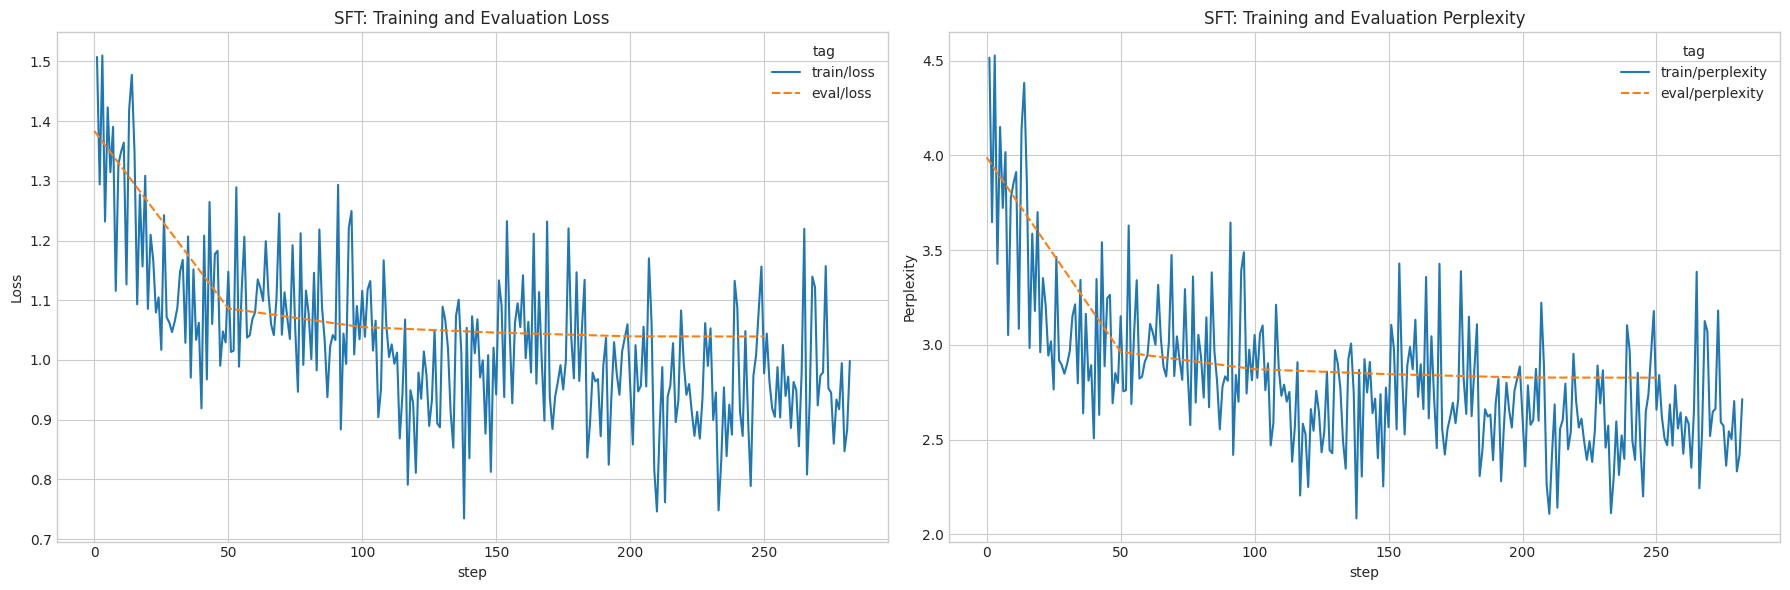

In [39]:
from tbparse import SummaryReader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

log_dir = "/tmp/content/tmp/tensorboard/SFT"
reader = SummaryReader(log_dir)
df = reader.scalars

# Pivot the data
df_pivot = df.pivot_table(index='step', columns='tag', values='value')

# -----------------------------------------------------------------------------
# 1. DEBUG: Print available tags to confirm names
# -----------------------------------------------------------------------------
print("✅ Available Tags in Logs:", df_pivot.columns.tolist())

# -----------------------------------------------------------------------------
# 2. PLOTTING
# -----------------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- Plot 1: Loss (Using 'train/loss' instead of 'loss/train') ---
# We use .get() or check existence to avoid crashing if a tag is missing
loss_cols = [c for c in ['train/loss', 'eval/loss'] if c in df_pivot.columns]

if loss_cols:
    sns.lineplot(data=df_pivot[loss_cols], ax=axes[0])
    axes[0].set_title('SFT: Training and Evaluation Loss')
    axes[0].set_ylabel('Loss')
else:
    axes[0].set_title('Error: Loss tags not found')

# --- Plot 2: Perplexity (More standard for LLMs than Accuracy) ---
# Your screenshots showed 'train/perplexity', so we plot that.
perp_cols = [c for c in ['train/perplexity', 'eval/perplexity'] if c in df_pivot.columns]

if perp_cols:
    sns.lineplot(data=df_pivot[perp_cols], ax=axes[1])
    axes[1].set_title('SFT: Training and Evaluation Perplexity')
    axes[1].set_ylabel('Perplexity')
else:
    # Fallback to accuracy if perplexity is missing
    acc_cols = [c for c in ['train/acc', 'eval/acc', 'train/accuracy', 'eval/accuracy'] if c in df_pivot.columns]
    if acc_cols:
        sns.lineplot(data=df_pivot[acc_cols], ax=axes[1])
        axes[1].set_title('SFT: Accuracy')
    else:
        axes[1].set_title('Metric not found (checked Perplexity/Accuracy)')

plt.tight_layout()
plt.show()

In [40]:
!ls -ltr /tmp/content/sft/ckpts/

/usr/local/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


total 16
drwxr-xr-x 3 root root 4096 Jan 11 04:20 150
drwxr-xr-x 3 root root 4096 Jan 11 04:23 200
drwxr-xr-x 3 root root 4096 Jan 11 04:27 250
drwxr-xr-x 3 root root 4096 Jan 11 04:29 282


In [41]:
import os

checkpoint_root = "/tmp/content/sft/ckpts"
steps = [int(d) for d in os.listdir(checkpoint_root) if d.isdigit()]

if not steps:
    print("No checkpoints found.")
else:
    latest_step = max(steps)
    trained_ckpt_path = os.path.join(checkpoint_root, str(latest_step), "model_params")
    
    print(f"✅ Latest checkpoint found: {latest_step}")
    print(f"📂 Path: {trained_ckpt_path}")

✅ Latest checkpoint found: 282
📂 Path: /tmp/content/sft/ckpts/282/model_params


In [42]:
# Clean up old SFT checkpoints to save space
if 'latest_step' in locals() and steps and 'checkpoint_root' in locals():
    print(f"Cleaning up old SFT checkpoints, keeping only step {latest_step}...")
    for step in steps:
        if step != latest_step:
            checkpoint_to_delete = os.path.join(checkpoint_root, str(step))
            try:
                # Use shutil.rmtree to recursively delete the directory
                shutil.rmtree(checkpoint_to_delete)
                print(f"  Deleted: {checkpoint_to_delete}")
            except OSError as e:
                print(f"  Error deleting {checkpoint_to_delete}: {e}")
    print("✅ Checkpoint cleanup complete.")

Cleaning up old SFT checkpoints, keeping only step 282...
  Deleted: /tmp/content/sft/ckpts/200
  Deleted: /tmp/content/sft/ckpts/150
  Deleted: /tmp/content/sft/ckpts/250
✅ Checkpoint cleanup complete.


In [43]:
! ls -ltr /tmp/content/sft/ckpts/

total 4
drwxr-xr-x 3 root root 4096 Jan 11 04:29 282


In [44]:
SFT_INTERMEDIATE_CKPT_DIR

'/tmp/content/sft/intermediate_ckpt/'

In [45]:
! ls -ltr /tmp/content/sft/intermediate_ckpt/state

total 156
-rw-r--r-- 1 root root 38435 Jan 11 03:57 _sharding
drwxr-xr-x 2 root root  4096 Jan 11 03:57 array_metadatas
drwxr-xr-x 3 root root  4096 Jan 11 03:58 ocdbt.process_0
-rw-r--r-- 1 root root 95582 Jan 11 03:58 _METADATA
drwxr-xr-x 2 root root  4096 Jan 11 03:58 d
-rw-r--r-- 1 root root   118 Jan 11 03:58 manifest.ocdbt
-rw-r--r-- 1 root root   262 Jan 11 03:58 _CHECKPOINT_METADATA


In [46]:
if wandb.run is not None:
    wandb.finish()

wandb.init(project="tunix-sft-demo", name=f"SFT_{NUM_EPOCHS}_epoch_{wandb_name}")

abs_params = jax.tree.map(
    lambda x: jax.ShapeDtypeStruct(x.shape, x.dtype),
    nnx.state(lora_policy, nnx.LoRAParam),
)
checkpointer = ocp.StandardCheckpointer()
trained_lora_params = checkpointer.restore(trained_ckpt_path, target=abs_params)

nnx.update(
    lora_policy,
    jax.tree.map(
        lambda a, b: b,
        nnx.state(lora_policy, nnx.LoRAParam),
        trained_lora_params,
    ),
)

print("✅ Successfully updated LoRA weights!")

ERROR:asyncio:Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x7da9d4419f40> is already entered
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-34048' coro=<_async_in_context.<locals>.run_in_context() done, defined at /usr/local/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-34049' coro=<Kernel.shell_main() running at /usr/local/lib/python3.12/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /usr/local/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>
/usr/local/lib/python3.12/site-packages/flax/nnx/variablelib.py:881: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  metadata 

✅ Successfully updated LoRA weights!


In [51]:

# Define the path for the final SFT LoRA checkpoint
SFT_LORA_CKPT_DIR = "/tmp/content/sft/lora_final/"
os.makedirs(SFT_LORA_CKPT_DIR, exist_ok=True)

# Extract only the LoRA parameters from the trained model
sft_lora_params = nnx.state(lora_policy, nnx.LoRAParam)

# Save the LoRA parameters using a PyTreeCheckpointer
checkpointer = ocp.PyTreeCheckpointer()
checkpointer.save(os.path.join(SFT_LORA_CKPT_DIR, "model_params"), sft_lora_params)

print(f"✅ SFT LoRA parameters saved to: {SFT_LORA_CKPT_DIR}")
!ls -l {SFT_LORA_CKPT_DIR}

✅ SFT LoRA parameters saved to: /tmp/content/sft/lora_final/
total 4
drwxr-xr-x 5 root root 4096 Jan 11 04:33 model_params


In [52]:
!ls -l {SFT_LORA_CKPT_DIR}

total 4
drwxr-xr-x 5 root root 4096 Jan 11 04:33 model_params


In [50]:
!apt-get update && apt-get install -y zip

Hit:1 http://deb.debian.org/debian trixie InRelease
Hit:2 http://deb.debian.org/debian trixie-updates InRelease
Hit:3 http://deb.debian.org/debian-security trixie-security InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
zip is already the newest version (3.0-15).
0 upgraded, 0 newly installed, 0 to remove and 58 not upgraded.


In [53]:
!zip -r sft_lora_checkpoint.zip {SFT_LORA_CKPT_DIR}

  adding: tmp/content/sft/lora_final/ (stored 0%)
  adding: tmp/content/sft/lora_final/model_params/ (stored 0%)
  adding: tmp/content/sft/lora_final/model_params/_CHECKPOINT_METADATA (deflated 38%)
  adding: tmp/content/sft/lora_final/model_params/d/ (stored 0%)
  adding: tmp/content/sft/lora_final/model_params/d/69ca8ce064bac0ece0c4dbd96e7addc8 (stored 0%)
  adding: tmp/content/sft/lora_final/model_params/_sharding (deflated 98%)
  adding: tmp/content/sft/lora_final/model_params/ocdbt.process_0/ (stored 0%)
  adding: tmp/content/sft/lora_final/model_params/ocdbt.process_0/d/ (stored 0%)
  adding: tmp/content/sft/lora_final/model_params/ocdbt.process_0/d/fd2f2d17d9673abdc299e5b00c6116bd (stored 0%)
  adding: tmp/content/sft/lora_final/model_params/ocdbt.process_0/d/04ff9d13f9930b86282fd82d778d1daf (deflated 0%)
  adding: tmp/content/sft/lora_final/model_params/ocdbt.process_0/d/1792d44afd6b816cf6f69a9f7c24649c (stored 0%)
  adding: tmp/content/sft/lora_final/model_params/ocdbt.process

In [54]:
import shutil

shutil.make_archive('/kaggle/working/sft_lora_checkpoint', 'zip', SFT_LORA_CKPT_DIR)

'/kaggle/working/sft_lora_checkpoint.zip'

## 1.8 Post-SFT Inference

Generate outputs using the SFT-trained model to verify format adherence and reasoning quality.

In [55]:
sampler = sampler_lib.Sampler(
    transformer=lora_policy,
    tokenizer=tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size=MAX_SEQ_LENGTH + TOTAL_GENERATION_STEPS,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

In [56]:
prompts = Universal_Test_df['Question'].tolist()
inf_batch_size = 4
results = []

for i in tqdm(range(0, len(prompts), inf_batch_size)):
    batch = prompts[i : i + inf_batch_size]
    batch_output = generate(batch, sampler) 
    results.extend(batch_output)

Universal_Test_df['SFT_Post_Training'] = results

100%|██████████| 120/120 [06:55<00:00,  3.46s/it]


In [57]:
Universal_Test_df.head()

,Dataset,Stage,Question,SFT_Pre_Training,SFT_Post_Training
0,Magicoder-Evol-Instruct,SFT,Construct a C++ program that illustrates the i...,<reasoning>\nHere's how we can solve this prob...,"<reasoning> The task requires two C++ arrays, ..."
1,marcuscedricridia/Qwill-RP-CreativeWriting-Rea...,SFT,Please write a story using the following writi...,## The Fall of the Crimson Comet\n\n<reasoning...,<reasoning> The core task is to write a story ...
2,LogiQA,SFT,Determine the logical relationship between the...,<reasoning>\nThe premise states that fossils o...,<reasoning> The premise presents a scenario wh...
3,allenai/sciq,SFT,Answer the following multiple choice question....,<reasoning>\nThe question asks for a group of ...,<reasoning> The question asks for a group of m...
4,marcuscedricridia/Qwill-RP-CreativeWriting-Rea...,SFT,Please write a story using the following writi...,## A Twist in the Woods\n\n<reasoning>\nThe da...,<reasoning> The user requires a short story ti...


In [58]:
Universal_Test_df.tail()

,Dataset,Stage,Question,SFT_Pre_Training,SFT_Post_Training
473,OpenCoder-LLM/opc-sft-stage2,GRPO1,Write a python function to find the longest su...,```python\ndef longest_Substring_Without_Repea...,<reasoning> The task requires finding the long...
474,OpenCoder-LLM/opc-sft-stage2,GRPO1,Write a Python function that takes a list of w...,```python\nfrom collections import defaultdict...,<reasoning> The core of this problem involves ...
475,OpenCoder-LLM/opc-sft-stage2,GRPO1,Write a function to calculate the minimum numb...,"```python\ndef min_num_squares(n):\n """"""\n C...",<reasoning> The core idea is to use dynamic pr...
476,OpenCoder-LLM/opc-sft-stage2,GRPO1,Write a function to find the minimum number of...,```python\ndef min_operations_palindrome(s: st...,<reasoning> The task is to find the minimum op...
477,OpenCoder-LLM/opc-sft-stage2,GRPO1,Write a python function to find the length of ...,```python\ndef longestSubarrayWithZeroSum(arr)...,<reasoning> The task requires finding the leng...


---

# 🔶 Stage 2: Direct Preference Optimization (DPO)

**Objective:** Refine the model's preferences by training on pairs of chosen (good) and rejected (bad) responses.

**Key Points:**
- Builds on SFT checkpoint as the reference model
- Uses KL divergence penalty (β=0.2) to prevent distribution collapse
- Optimizes the policy to prefer "chosen" responses over "rejected" ones

**DPO Loss Function:**
$$\mathcal{L}_{DPO} = -\log\sigma\left(\beta \cdot \left[\log\frac{\pi_\theta(y_w|x)}{\pi_{ref}(y_w|x)} - \log\frac{\pi_\theta(y_l|x)}{\pi_{ref}(y_l|x)}\right]\right)$$

Where $y_w$ is the chosen response and $y_l$ is the rejected response.

In [59]:
try:
    del trainer 
    del optimizer
    del train_grain
    del eval_grain
    del formatted_train_data
    del formatted_test_data
    del data_df
    del train_df
    del test_df
    del train_split
    del test_split
    del ref_model
    del sampler
    del training_config
    del checkpointing_options
    del metrics_logging_options
except:
    print("Exception occured")
    pass

# Force garbage collection
import gc
gc.collect()

# Clear JAX memory caches
jax.clear_caches()

print("🧹 SFT Trainer, optimizer, datasets, base model, sampler, and all configs removed to free memory.")

🧹 SFT Trainer, optimizer, datasets, base model, sampler, and all configs removed to free memory.


In [60]:
from pprint import pprint
from typing import List, Dict, Any
import csv
import shutil
import functools, gc, os, re, asyncio, subprocess, tempfile, resource, signal, itertools, sys, time, datetime, random, contextlib, io, traceback
from concurrent.futures import ThreadPoolExecutor, as_completed

from flax import nnx
import grain
import humanize
import jax
import jax.numpy as jnp
import kagglehub
import optax
from orbax import checkpoint as ocp
from pathlib import Path
import qwix
import tensorflow_datasets as tfds
from tqdm.auto import tqdm
from tunix.generate import sampler as sampler_lib
from tunix.generate import tokenizer_adapter as tokenizer_lib

from tunix.models.gemma import model as gemma_lib
from tunix.models.gemma import params as params_lib
from tunix.models.gemma3 import params
from tunix.models.gemma3 import model
from tunix.rl import rl_cluster as rl_cluster_lib
from tunix.rl.grpo.grpo_learner import GRPOConfig, GRPOLearner
from tunix.sft.dpo.dpo_trainer import DPOTrainer
from tunix.sft.dpo.dpo_trainer import DPOTrainingConfig
from tunix.rl.rollout import base_rollout
from tunix.sft import metrics_logger
#from datasets import load_dataset
from huggingface_hub import login
#import datasets.utils.logging

from sklearn.model_selection import train_test_split
from tqdm import tqdm

## 2.1 DPO Training Data

**Dataset:** `sandeeplleb/dpo-final/DPO_v5.xlsx`

The DPO dataset contains preference pairs with:
- `prompt`: The original user query
- `CHOSEN`: The preferred response (correct format, accurate reasoning)
- `REJECTED`: The non-preferred response (poor format, incorrect reasoning, or wrong answer)

**Data Distribution:** Stratified across domains to maintain balance

In [61]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

def get_df():
    return kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "sandeeplleb/dpo-final",
  "DPO_v5.xlsx",
)

data_df = get_df()

data_df.head()

,Version,UCID,Dataset,prompt,CHOSEN,REJECTED,chosen_score,rejected_score,chosen_source,rejected_source,Input_tokens,Chosen_tokens,Rejected_tokens
0,PreSoiled,473,Intel/orca_dpo_pairs,You are an AI assistant. You will be given a t...,"<reasoning>\nOkay, let's craft a good question...",<reasoning>\n- The plot involves a romantic si...,1020,1013,Gemma_Gen2,Gemini_Gen,627,537,169
1,PreSoiled,8062,Intel/orca_dpo_pairs,"You are a helpful assistant, who always provid...",<reasoning>\n- The sentence to translate is 'o...,"<reasoning>\nOkay, let's translate ""of the Con...",1020,1013,Gemini_Gen,Gemma_Gen1,151,123,145
2,PreSoiled,1752,Intel/orca_dpo_pairs,\nQ:I want to test the ability of students to ...,"<reasoning>\nOkay, let's craft a good comprehe...",<reasoning>\n- The question should test compre...,1020,1013,Gemma_Gen2,Gemini_Gen,332,492,105
3,PreSoiled,2521,gursi26/wikihow-cleaned,Read the text below. Provide a suitable title ...,<reasoning>\nThe text describes how to create ...,<reasoning>\nThis text describes how to make a...,1019,1013,Gemini_Gen,Gemma_Gen2,209,461,768
4,PreSoiled,2244,Intel/orca_dpo_pairs,"You are a helpful assistant, who always provid...",<reasoning>\n* Let's read the text carefully. ...,<reasoning>\nWe know that Will Wheaton was bor...,1019,1013,Gemini_Gen,Gemma_Gen3,212,480,766


In [62]:
eos_token = "<end_of_turn>"

def ensure_eos(text):
    text = str(text)
    # 1. Strip whitespace from the right side to handle "text<end_of_turn>  "
    # 2. Check if it ends with the token
    if not text.rstrip().endswith(eos_token):
        return text + eos_token
    return text

data_df['CHOSEN'] = data_df['CHOSEN'].apply(ensure_eos)
data_df['REJECTED'] = data_df['REJECTED'].apply(ensure_eos)

In [63]:
#data_df = data_df.head(1000)

In [64]:
data_df.shape

(6130, 13)

In [ ]:
import random
random_integer = random.randint(0, len(data_df))
print(data_df['prompt'][random_integer])
print("="*60)
print(data_df['CHOSEN'][random_integer])
print("="*60)
print(data_df['REJECTED'][random_integer])

In [66]:
train_split, test_split = train_test_split(
    data_df,
    test_size=0.05,
    stratify=data_df['Dataset'], # Maintain distribution
    random_state=42,
    shuffle=True
)

train_df = train_split.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_split.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Train Data shape: {train_split.shape}\nTest Data shape: {test_split.shape}")

Train Data shape: (5823, 13)
Test Data shape: (307, 13)


## 2.2 DPO Hyperparameters

| Category | Parameter | Value | Rationale |
|----------|-----------|-------|-----------|
| **DPO** | β (Beta) | 0.2 | KL divergence penalty strength |
| | Max Prompt Length | 1024 | Prompt token limit |
| | Max Response Length | 1024 | Response token limit |
| **Training** | Micro Batch Size | 4 | Larger than SFT (pairs are smaller) |
| | Gradient Accumulation | 8 | Effective batch = 32 |
| | Epochs | 1 | DPO typically needs fewer epochs |
| **Optimizer** | Learning Rate | 3e-6 | Lower than SFT for stability |
| | Scheduler | Warmup + Cosine Decay | 10% warmup |
| | Weight Decay | 0.1 | AdamW regularization |
| | Gradient Clipping | 0.1 | Prevent KL divergence explosion |

In [67]:
# ====== Data ======
TRAIN_DATA_DIR = "./data/train"
TEST_DATA_DIR = "./data/test"
TRAIN_FRACTION = 1.0

# ====== LoRA ======
RANK = 64
ALPHA = 64.0

# ====== Sharding ======
MESH = [(8, 1), ("fsdp", "tp")]

# ====== DPO ======
MAX_PROMPT_LENGTH = 1024
MAX_RESPONSE_LENGTH = 1024
TEMPERATURE = 0.9
TOP_P = 1.0
TOP_K = 50
# The coefficient for the KL divergence penalty (𝛽) in the DPO loss function.
# Important to keep a high enough value for this, otherwise, the KL divergence
# can increase unchecked.
BETA = 0.2

# ====== Training ======
GRADIENT_ACCUMULATION_STEPS = 8
TRAIN_MICRO_BATCH_SIZE = 4

EVAL_EVERY_N_STEPS = 100
NUM_EPOCHS = 1

# === AdamW, warmup, cosine scheduler ===
LEARNING_RATE = 3e-6
B1 = 0.9
B2 = 0.99
WEIGHT_DECAY = 0.1

EFFECTIVE_BATCH_SIZE = TRAIN_MICRO_BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS
STEPS_PER_EPOCH = len(train_df) // EFFECTIVE_BATCH_SIZE
MAX_STEPS = STEPS_PER_EPOCH * NUM_EPOCHS
WARMUP_STEPS = int(0.1 * MAX_STEPS)


# == Grad clipping ==
# Grad clipping to prevent large gradients. Found this
# important to keep KL divergence in check.
MAX_GRAD_NORM = 0.1

# Checkpoint saving (DPO)
DPO_INTERMEDIATE_CKPT_DIR = "/tmp/content/dpo/intermediate_ckpt/"
DPO_CKPT_DIR = "/tmp/content/dpo/ckpts/"
SAVE_INTERVAL_STEPS = 500
MAX_TO_KEEP = 4

# ====== Inference ======
GENERATION_CONFIGS = {
    # greedy search
    "greedy": {"temperature": 1e-4, "top_k": 1, "top_p": 1.0},
    # some randomness
    "standard": {"temperature": 0.7, "top_k": 50, "top_p": 0.95},
    # liberal
    "liberal": {"temperature": 0.85, "top_k": 2000, "top_p": 1.0},
}

In [68]:
print(f"Training on {len(train_df)} samples. Max Steps: {MAX_STEPS}")

Training on 5823 samples. Max Steps: 181


## 2.3 DPO Dataset Preparation

Create Grain datasets with the DPO-required format: `prompts`, `chosen_responses`, `rejected_responses`.

In [69]:
BASE_SYSTEM_PROMPT  = """<start_of_turn>user 
You are a meticulous AI expert. Your task is to solve a problem by first showing your work and then stating the final answer.

INSTRUCTIONS:
1.  **Reasoning:** Break down the problem and explain your thought process. Enclose this entire thought process in between <reasoning> and </reasoning>.
2.  **Answer:** State only the final, conclusive answer. Enclose it in between <answer> and </answer>.

TASK:
'''
{task}
'''
<end_of_turn>
<start_of_turn>model
"""

In [70]:
def create_grain_dataset(dataframe):
    """Converts a Pandas DataFrame to a grain MapDataset for DPO."""
    
    # Convert DF to list of dicts
    data_source = dataframe.to_dict('records')
    
    # Define mapping function to format keys required by DPOTrainer
    def format_dpo_entry(row):
        # Construct the full prompt
        full_prompt = BASE_SYSTEM_PROMPT.format(task=row['prompt'])
        
        return {
            "prompts": full_prompt,
            "chosen_responses": str(row['CHOSEN']),
            "rejected_responses": str(row['REJECTED'])
        }

    dataset = grain.MapDataset.source(data_source).map(format_dpo_entry)
    return dataset

# Create Datasets
train_ds = create_grain_dataset(train_df).batch(TRAIN_MICRO_BATCH_SIZE).repeat(NUM_EPOCHS)

# Create Validation Dataset [Full]
val_ds = create_grain_dataset(test_df).batch(TRAIN_MICRO_BATCH_SIZE)

# Create Validation Dataset (taking a small slice for speed) as we will be passing it to the TRAINER loop
val_ds_small = create_grain_dataset(
    test_df.sample(n=20 * TRAIN_MICRO_BATCH_SIZE, random_state=42) 
).batch(TRAIN_MICRO_BATCH_SIZE)

In [ ]:
train_ds[0]

## 2.4 DPO Model Setup

Load a fresh reference model and policy model, both initialized from the SFT checkpoint. The reference model stays frozen while the policy model is updated.

In [72]:
model_path = {
    "gemma2": "google/gemma-2/flax/",
}
model_family = "gemma2"
model_version = "gemma2-2b-it"
print(f"{model_path[model_family]}{model_version}")

kaggle_ckpt_path = kagglehub.model_download(
    f"{model_path[model_family]}{model_version}"
)

google/gemma-2/flax/gemma2-2b-it


In [73]:
def get_gemma_ref_model(ckpt_path):
  mesh = jax.make_mesh(*MESH)
  model_config = gemma_lib.ModelConfig.gemma2_2b()
  abs_gemma: nnx.Module = nnx.eval_shape(
      lambda: gemma_lib.Transformer(model_config, rngs=nnx.Rngs(params=0))
  )
  abs_state = nnx.state(abs_gemma)
  abs_state = jax.tree.map(
      lambda a, s: jax.ShapeDtypeStruct(a.shape, jnp.bfloat16, sharding=s),
      abs_state,
      nnx.get_named_sharding(abs_state, mesh),
  )
  checkpointer = ocp.StandardCheckpointer()
  restored_params = checkpointer.restore(ckpt_path, target=abs_state)

  graph_def, _ = nnx.split(abs_gemma)
  gemma = nnx.merge(graph_def, restored_params)
  return gemma, mesh, model_config


def get_lora_model(base_model, mesh):
  lora_provider = qwix.LoraProvider(
      module_path=(
          ".*q_einsum|.*kv_einsum|.*gate_proj|.*down_proj|.*up_proj|"
          ".*attn_vec_einsum"
      ),
      rank=RANK,
      alpha=ALPHA,
  )

  model_input = base_model.get_model_input()
  lora_model = qwix.apply_lora_to_model(
      base_model, lora_provider, **model_input
  )

  with mesh:
    state = nnx.state(lora_model)
    pspecs = nnx.get_partition_spec(state)
    sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
    nnx.update(lora_model, sharded_state)

  return lora_model

In [74]:
base_ref, _, _ = get_gemma_ref_model(os.path.join(SFT_INTERMEDIATE_CKPT_DIR, "state"))
ref_model = get_lora_model(base_ref, mesh)

# 3. Sync Weights: Load the SFT checkpoint into this new reference model
checkpointer = ocp.StandardCheckpointer()
abs_params = jax.tree.map(
    lambda x: jax.ShapeDtypeStruct(x.shape, x.dtype),
    nnx.state(ref_model, nnx.LoRAParam),
)
trained_lora_params = checkpointer.restore(trained_ckpt_path, target=abs_params)

# Update the reference model state
nnx.update(ref_model, trained_lora_params)

print("✅ Reference model loaded as a separate object.")

/usr/local/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/jax_array_handlers.py:621: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


✅ Reference model loaded as a separate object.


## 2.5 DPO Training Configuration

Configure the Tunix `DPOTrainer` with the optimizer and training parameters.

In [75]:
# Ckpt saving
checkpointing_options = ocp.CheckpointManagerOptions(
    save_interval_steps=SAVE_INTERVAL_STEPS, max_to_keep=MAX_TO_KEEP
)

# Metrics logger
metrics_logging_options = metrics_logger.MetricsLoggerOptions(
    log_dir="/tmp/content/tmp/tensorboard/DPO", flush_every_n_steps=20
)

In [76]:
# Optimizer, learning rate scheduler, gradient clipping
optimizer = optax.adamw(
    learning_rate=optax.schedules.warmup_cosine_decay_schedule(
        init_value=1e-6,
        peak_value=LEARNING_RATE,
        warmup_steps=WARMUP_STEPS,
        decay_steps=int(MAX_STEPS),
        end_value=LEARNING_RATE*0.1,
    ),
    b1=B1,
    b2=B2,
    weight_decay=WEIGHT_DECAY,
)
if MAX_GRAD_NORM is not None:
  optimizer = optax.chain(
      optax.clip_by_global_norm(max_norm=MAX_GRAD_NORM),
      optimizer,
  )

In [77]:
# DPO training config
dpo_config = DPOTrainingConfig(
    beta=BETA,
    eval_every_n_steps=EVAL_EVERY_N_STEPS,
    max_steps=MAX_STEPS,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    max_prompt_length=MAX_PROMPT_LENGTH,
    max_response_length=MAX_RESPONSE_LENGTH,
    metrics_logging_options=metrics_logging_options,
    checkpoint_root_directory=DPO_CKPT_DIR,
    checkpointing_options=checkpointing_options,
)

In [78]:
# DPO Trainer
dpo_trainer = DPOTrainer(
    model=lora_policy,
    ref_model=ref_model,
    optimizer=optimizer,
    training_config=dpo_config,
    tokenizer=tokenizer,
)

jax/core/compile/backend_compile_duration,▁
jax/core/compile/jaxpr_to_mlir_module_duration,▁
jax/core/compile/jaxpr_trace_duration,▁
jax/orbax/write/replicated_array_gb,▁
jax/orbax/write/sharded_array_gb,▁
jax/core/compile/backend_compile_duration,1768106547.38801
jax/core/compile/jaxpr_to_mlir_module_duration,1768106547.38026
jax/core/compile/jaxpr_trace_duration,1768106547.37901
jax/orbax/write/replicated_array_gb,0.0011
jax/orbax/write/sharded_array_gb,0.00027


## 2.6 Pre-DPO Inference (Baseline)

Generate baseline outputs before DPO training for comparison.

In [79]:
def generate(question, sampler, temperature=0.7, top_k=50, top_p=0.95, seed=None):
  if isinstance(question, str):
    BASE_SYSTEM_PROMPT.format(task = question)
    input_batch = [
        BASE_SYSTEM_PROMPT.format(task = question),
    ]
  else:
    input_batch = [
        BASE_SYSTEM_PROMPT.format(          
            task=q,
        )
        for q in question
    ]

  out_data = sampler(
      input_strings=input_batch,
      max_generation_steps=768,
      temperature=temperature,
      top_k=top_k,
      top_p=top_p,
      echo=False,
      seed=seed if seed is not None else None,
      eos_tokens=[1,106],
  )

  output = out_data.text
  if isinstance(question, str):
    return output[0]
  return output

In [80]:
sampler = sampler_lib.Sampler(
    transformer=lora_policy,
    tokenizer=tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size= MAX_PROMPT_LENGTH + MAX_RESPONSE_LENGTH,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

In [81]:
if wandb.run is not None:
    wandb.finish()

wandb.init(project="tunix-DPO-demo", name=f"DPO_{NUM_EPOCHS}_epoch_{wandb_name}")

In [82]:
Universal_Test_df.head()

,Dataset,Stage,Question,SFT_Pre_Training,SFT_Post_Training
0,Magicoder-Evol-Instruct,SFT,Construct a C++ program that illustrates the i...,<reasoning>\nHere's how we can solve this prob...,"<reasoning> The task requires two C++ arrays, ..."
1,marcuscedricridia/Qwill-RP-CreativeWriting-Rea...,SFT,Please write a story using the following writi...,## The Fall of the Crimson Comet\n\n<reasoning...,<reasoning> The core task is to write a story ...
2,LogiQA,SFT,Determine the logical relationship between the...,<reasoning>\nThe premise states that fossils o...,<reasoning> The premise presents a scenario wh...
3,allenai/sciq,SFT,Answer the following multiple choice question....,<reasoning>\nThe question asks for a group of ...,<reasoning> The question asks for a group of m...
4,marcuscedricridia/Qwill-RP-CreativeWriting-Rea...,SFT,Please write a story using the following writi...,## A Twist in the Woods\n\n<reasoning>\nThe da...,<reasoning> The user requires a short story ti...


## 2.7 DPO Training Loop

Run Direct Preference Optimization. Key metrics to monitor:
- **Rewards (Chosen vs Rejected):** Gap should widen over training
- **Margin:** Distance between chosen and rejected rewards
- **Accuracy:** How often the model assigns higher probability to chosen responses

In [83]:
print("Starting Training...")

if wandb.run is not None:
    wandb.finish()
wandb.init(project="tunix-DPO-demo", name=f"DPO_{NUM_EPOCHS}_epoch_{wandb_name}")

with mesh:
    dpo_trainer.train(train_ds, val_ds_small)
print("Training Complete.")

Starting Training...


Training:   0%|          | 0/181 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 0 that is less than the current step 1. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 2. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 3. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 4. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 5. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/defin

eval/log_probs/chosen,▁█
eval/log_probs/rejected,▁█
eval/loss,█▁
eval/perplexity,█▁
eval/rewards/accuracy,▁█
eval/rewards/chosen,▁█
eval/rewards/margin,▁█
eval/rewards/rejected,▁█
eval/step_time_sec,▁▁
eval/steps_per_sec,▁▁
+16,...


Training Complete.


✅ Available Tags: ['eval/log_probs/chosen', 'eval/log_probs/rejected', 'eval/loss', 'eval/perplexity', 'eval/rewards/accuracy', 'eval/rewards/chosen', 'eval/rewards/margin', 'eval/rewards/rejected', 'eval/step_time_sec', 'eval/steps_per_sec', 'jax/core/compile/backend_compile_duration', 'jax/core/compile/jaxpr_to_mlir_module_duration', 'jax/core/compile/jaxpr_trace_duration', 'jax/orbax/write/replicated_array_gb', 'jax/orbax/write/sharded_array_gb', 'train/log_probs/chosen', 'train/log_probs/rejected', 'train/loss', 'train/perplexity', 'train/rewards/accuracy', 'train/rewards/chosen', 'train/rewards/margin', 'train/rewards/rejected', 'train/step_time_sec', 'train/steps_per_sec', 'train/tflops_per_step']


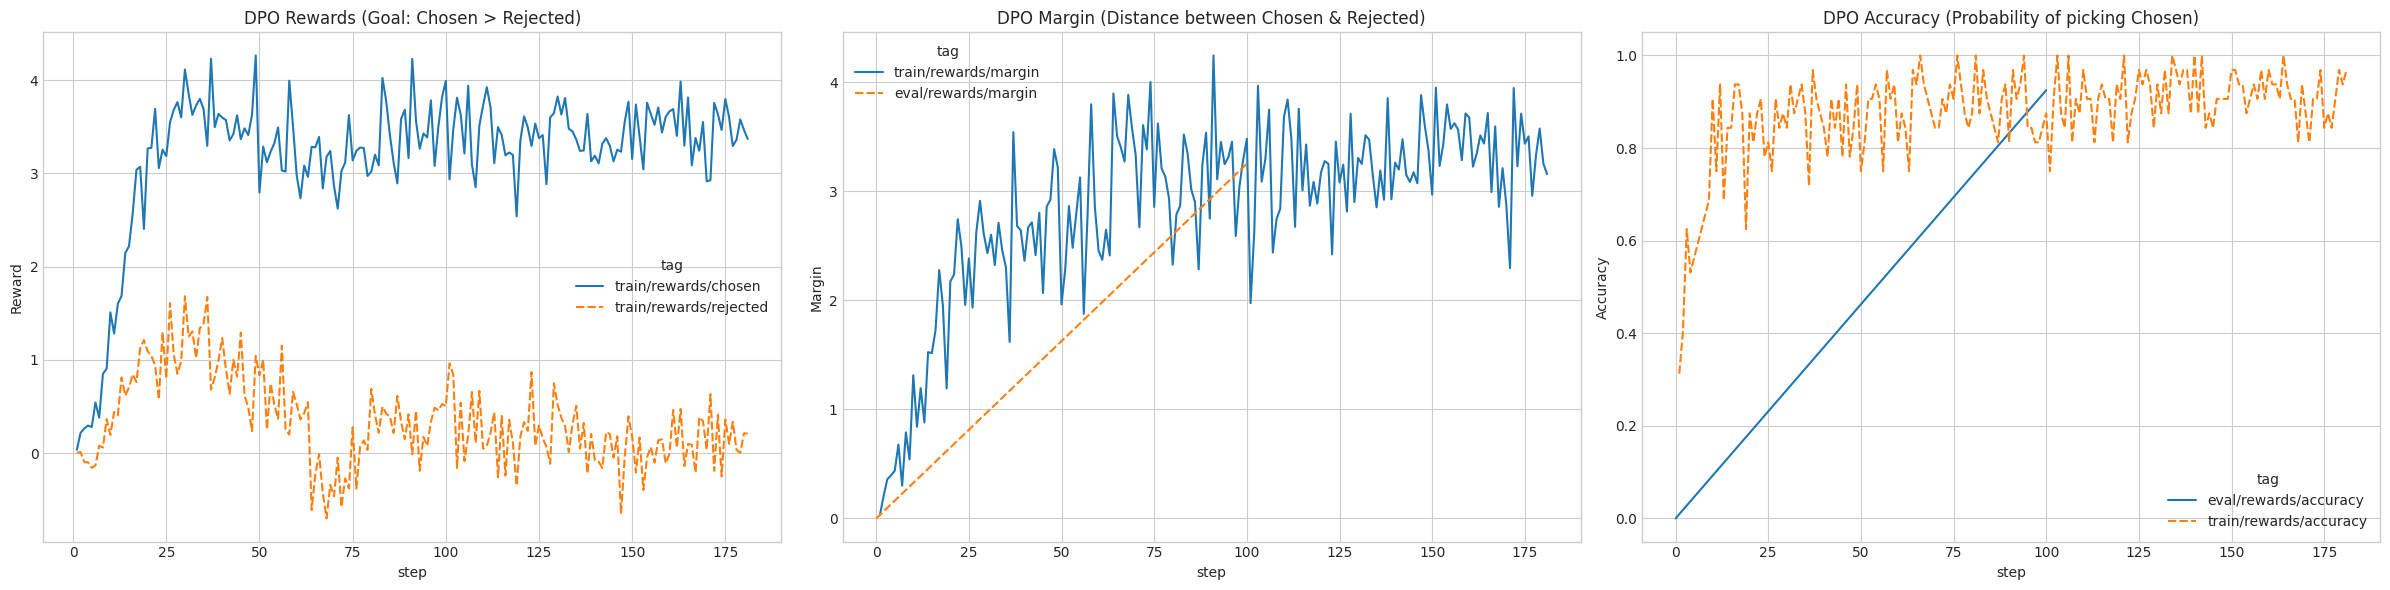

In [84]:
from tbparse import SummaryReader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

log_dir = "/tmp/content/tmp/tensorboard/DPO"
reader = SummaryReader(log_dir)
df = reader.scalars

# Pivot the data
df_pivot = df.pivot_table(index='step', columns='tag', values='value')

print("✅ Available Tags:", df_pivot.columns.tolist())

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# --- Plot 1: Rewards (Chosen vs Rejected) ---
# GOAL: 'chosen' should go UP, 'rejected' should go DOWN.
reward_cols = [c for c in ['train/rewards/chosen', 'train/rewards/rejected'] if c in df_pivot.columns]
if reward_cols:
    sns.lineplot(data=df_pivot[reward_cols], ax=axes[0])
    axes[0].set_title('DPO Rewards (Goal: Chosen > Rejected)')
    axes[0].set_ylabel('Reward')
else:
    axes[0].set_title('Rewards tag not found')

# --- Plot 2: Margin ---
# GOAL: Margin should go UP (Margin = Chosen - Rejected)
margin_cols = [c for c in ['train/rewards/margin', 'eval/rewards/margin'] if c in df_pivot.columns]
if margin_cols:
    sns.lineplot(data=df_pivot[margin_cols], ax=axes[1])
    axes[1].set_title('DPO Margin (Distance between Chosen & Rejected)')
    axes[1].set_ylabel('Margin')
else:
    axes[1].set_title('Margin tag not found')

# --- Plot 3: Classification Accuracy ---
# GOAL: Should approach 1.0 (How often model picks the "Chosen" answer)
acc_cols = [c for c in ['eval/rewards/accuracy', 'train/rewards/accuracy'] if c in df_pivot.columns]
if acc_cols:
    sns.lineplot(data=df_pivot[acc_cols], ax=axes[2])
    axes[2].set_title('DPO Accuracy (Probability of picking Chosen)')
    axes[2].set_ylabel('Accuracy')
else:
    # Fallback to Loss if accuracy isn't there
    loss_cols = [c for c in ['train/loss', 'train/dpo_loss'] if c in df_pivot.columns]
    if loss_cols:
        sns.lineplot(data=df_pivot[loss_cols], ax=axes[2])
        axes[2].set_title('DPO Loss')
    else:
        axes[2].set_title('Metric not found')

plt.tight_layout()
plt.show()

In [85]:
!ls -ltr /tmp/content/dpo/ckpts/

/usr/local/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


total 8
drwxr-xr-x 3 root root 4096 Jan 11 04:46 1
drwxr-xr-x 3 root root 4096 Jan 11 05:01 181


In [86]:
import os

checkpoint_root = "/tmp/content/dpo/ckpts"
steps = [int(d) for d in os.listdir(checkpoint_root) if d.isdigit()]

if not steps:
    print("No checkpoints found.")
else:
    latest_step = max(steps)
    trained_ckpt_path = os.path.join(checkpoint_root, str(latest_step), "model_params")
    
    print(f"✅ Latest checkpoint found: {latest_step}")
    print(f"📂 Path: {trained_ckpt_path}")

✅ Latest checkpoint found: 181
📂 Path: /tmp/content/dpo/ckpts/181/model_params


In [87]:
if wandb.run is not None:
    wandb.finish()
wandb.init(project="tunix-DPO-demo", name=f"DPO_{NUM_EPOCHS}_epoch_{wandb_name}")


abs_params = jax.tree.map(
    lambda x: jax.ShapeDtypeStruct(x.shape, x.dtype),
    nnx.state(lora_policy, nnx.LoRAParam),
)
checkpointer = ocp.StandardCheckpointer()
trained_lora_params = checkpointer.restore(trained_ckpt_path, target=abs_params)

nnx.update(
    lora_policy,
    jax.tree.map(
        lambda a, b: b,
        nnx.state(lora_policy, nnx.LoRAParam),
        trained_lora_params,
    ),
)

print("✅ Successfully updated LoRA weights!")

/usr/local/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/jax_array_handlers.py:621: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


✅ Successfully updated LoRA weights!


In [88]:
# Define the path for the final DPO LoRA checkpoint
DPO_LORA_CKPT_DIR = "/tmp/content/dpo/lora_final/"
os.makedirs(DPO_LORA_CKPT_DIR, exist_ok=True)

# Extract only the LoRA parameters from the DPO-trained model
dpo_lora_params = nnx.state(lora_policy, nnx.LoRAParam)

# Save the LoRA parameters
checkpointer = ocp.PyTreeCheckpointer()
checkpointer.save(os.path.join(DPO_LORA_CKPT_DIR, "model_params"), dpo_lora_params)

print(f"✅ DPO LoRA parameters saved to: {DPO_LORA_CKPT_DIR}")
!ls -l {DPO_LORA_CKPT_DIR}

ERROR:asyncio:Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x7da9d4419f40> is already entered
ERROR:asyncio:Exception in callback Task.__step()
handle: <Handle Task.__step()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x7da9d4419f40> is already entered


✅ DPO LoRA parameters saved to: /tmp/content/dpo/lora_final/
total 4
drwxr-xr-x 5 root root 4096 Jan 11 05:14 model_params


In [89]:
!zip -r dpo_lora_checkpoint.zip {DPO_LORA_CKPT_DIR}

  adding: tmp/content/dpo/lora_final/ (stored 0%)
  adding: tmp/content/dpo/lora_final/model_params/ (stored 0%)
  adding: tmp/content/dpo/lora_final/model_params/_CHECKPOINT_METADATA (deflated 38%)
  adding: tmp/content/dpo/lora_final/model_params/d/ (stored 0%)
  adding: tmp/content/dpo/lora_final/model_params/d/0dc7db9659590f16446576f22def9211 (deflated 1%)
  adding: tmp/content/dpo/lora_final/model_params/_sharding (deflated 98%)
  adding: tmp/content/dpo/lora_final/model_params/ocdbt.process_0/ (stored 0%)
  adding: tmp/content/dpo/lora_final/model_params/ocdbt.process_0/d/ (stored 0%)
  adding: tmp/content/dpo/lora_final/model_params/ocdbt.process_0/d/daaeee849bf016790932403be323f36c (deflated 0%)
  adding: tmp/content/dpo/lora_final/model_params/ocdbt.process_0/d/80d9bf09f1c05ebee659765d282b43ba (stored 0%)
  adding: tmp/content/dpo/lora_final/model_params/ocdbt.process_0/d/5654212422cf820f3a92853a84dab67f (stored 0%)
  adding: tmp/content/dpo/lora_final/model_params/ocdbt.proce

In [90]:
import shutil

shutil.make_archive('/kaggle/working/dpo_lora_checkpoint', 'zip', DPO_LORA_CKPT_DIR)

'/kaggle/working/dpo_lora_checkpoint.zip'

## 2.8 Post-DPO Inference

Generate outputs using the DPO-trained model and save results for comparison.

In [91]:
sampler = sampler_lib.Sampler(
    transformer=lora_policy,
    tokenizer=tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size= MAX_PROMPT_LENGTH + MAX_RESPONSE_LENGTH,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-80595' coro=<_async_in_context.<locals>.run_in_context() done, defined at /usr/local/lib/python3.12/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-80598' coro=<Kernel.shell_main() running at /usr/local/lib/python3.12/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /usr/local/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>
/usr/local/lib/python3.12/site-packages/jax/_src/core.py:2573: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  def __instancecheck__(self, inst):
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-80598' coro=<Kernel.shell_main() running at /usr/local/lib/python3.12/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]>


In [92]:
prompts = Universal_Test_df['Question'].tolist()
inf_batch_size = 4
results = []

for i in tqdm(range(0, len(prompts), inf_batch_size)):
    batch = prompts[i : i + inf_batch_size]
    batch_output = generate(batch, sampler)
    results.extend(batch_output)

Universal_Test_df['DPO_Post_Training'] = results

  0%|          | 0/120 [00:00<?, ?it/s]ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-77778' coro=<_async_in_context.<locals>.run_in_context() running at /usr/local/lib/python3.12/site-packages/ipykernel/utils.py:60> wait_for=<Task pending name='Task-80591' coro=<Kernel.shell_main() running at /usr/local/lib/python3.12/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /usr/local/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py:563]>
/usr/local/lib/python3.12/site-packages/jax/_src/util.py:404: RuntimeWarning: coroutine 'Kernel.shell_main' was never awaited
  return tuple(weakrefs_to_sentinel(v1, acc) for v1 in v)
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-80591' coro=<Kernel.shell_main() running at /usr/local/lib/python3.12/site-packages/ipykernel/kernelbase.py:590> cb=[Task.__wakeup()]>
100%|██████████| 120/120 [06:42<00:00,  3.35s/it]


In [93]:
Universal_Test_df.to_excel('./TestResults_SFT_3e_and_DPO_1e.xlsx')

In [94]:
Universal_Test_df.head()

,Dataset,Stage,Question,SFT_Pre_Training,SFT_Post_Training,DPO_Post_Training
0,Magicoder-Evol-Instruct,SFT,Construct a C++ program that illustrates the i...,<reasoning>\nHere's how we can solve this prob...,"<reasoning> The task requires two C++ arrays, ...",<reasoning> The task requires a C++ program to...
1,marcuscedricridia/Qwill-RP-CreativeWriting-Rea...,SFT,Please write a story using the following writi...,## The Fall of the Crimson Comet\n\n<reasoning...,<reasoning> The core task is to write a story ...,<reasoning> The core task is to write a short ...
2,LogiQA,SFT,Determine the logical relationship between the...,<reasoning>\nThe premise states that fossils o...,<reasoning> The premise presents a scenario wh...,<reasoning> The premise presents a scenario wh...
3,allenai/sciq,SFT,Answer the following multiple choice question....,<reasoning>\nThe question asks for a group of ...,<reasoning> The question asks for a group of m...,Reasoning:\n1. **Identify the core concept:**...
4,marcuscedricridia/Qwill-RP-CreativeWriting-Rea...,SFT,Please write a story using the following writi...,## A Twist in the Woods\n\n<reasoning>\nThe da...,<reasoning> The user requires a short story ti...,<reasoning> I need to craft a short story titl...


---

# 🔷 Stage 3: Group Relative Policy Optimization (GRPO)

**Objective:** Use reinforcement learning with reward functions to further improve answer accuracy and reasoning quality.

**Key Points:**
- Generates multiple responses per prompt and ranks them by reward
- Uses reward functions for format verification and answer correctness
- Builds on DPO checkpoint as the starting point
- Two sub-stages: Math-focused GRPO, then Multi-domain GRPO

**GRPO Advantage:**
- No need for a separate reward model - uses programmatic reward functions
- Group-based normalization reduces variance in policy gradients

In [95]:
import sys
import gc
import jax

print("🧹 STARTING CLEANUP...")

# 1. Clear Jupyter History
try:
    ip = get_ipython()
    ip.display_pub.clear_output()
    ip.history_manager.reset()
except:
    pass

# 2. Delete Variables
targets = [
    'trainer', 'dpo_trainer', 'optimizer', 'training_config', 'cluster_config', 
    'metrics_logging_options', 'checkpointing_options', 'grpo_config', 
    'rl_cluster', 'grpo_trainer', 'ref_model', 'lora_policy', 'base_model', 
    'base_ref', 'model', 'gemma', 'base_model_ref', 'base_model_policy',
    'train_ds', 'val_ds', 'val_ds_small', 'params', 'sft_params', 'dpo_params',
    'trained_lora_params', 'dpo_lora_params', 'sft_lora_params', 'abs_params', 
    'restored_params', 'state', 'graph_def', 'mesh', 'grpo_mesh', 'train_grain', 'eval_grain', 'static', 'data_df', 'train_df', 'test_df', 'train_split', 'test_split', 'sampler'
]

for t in targets:
    if t in globals():
        try:
            del globals()[t]
        except:
            pass

# 3. Force Memory Release
gc.collect()
jax.clear_caches()

# 4. Verify
print("\n🔄 Verifying Memory Release...")
try:
    device = jax.local_devices()[0]
    stats = device.memory_stats()
    print(f"Used: {stats['bytes_in_use'] / 1e9:.2f} GB")
    print(f"Free: {(stats['bytes_limit'] - stats['bytes_in_use']) / 1e9:.2f} GB")
except:
    pass


🔄 Verifying Memory Release...
Used: 0.00 GB
Free: 16.91 GB


In [96]:
import functools
import gc
import os
from pprint import pprint
import re

import csv
import shutil

from flax import nnx
import grain
import humanize
import jax
import jax.numpy as jnp
import kagglehub
import optax
from orbax import checkpoint as ocp
from pathlib import Path
import qwix
import tensorflow_datasets as tfds
from tqdm.auto import tqdm
from tunix.generate import sampler as sampler_lib
from tunix.generate import tokenizer_adapter as tokenizer_lib
from tunix.models.gemma import model as gemma_lib
from tunix.models.gemma import params as params_lib
from tunix.rl import rl_cluster as rl_cluster_lib
from tunix.rl.grpo.grpo_learner import GRPOConfig, GRPOLearner
from tunix.rl.rollout import base_rollout
from tunix.sft import metrics_logger
from sklearn.model_selection import train_test_split

## 3.1 GRPO Hyperparameters

| Category | Parameter | Value | Rationale |
|----------|-----------|-------|-----------|
| **GRPO** | Num Generations | 4 | Responses generated per prompt |
| | β (Beta) | 0.08 | KL penalty (lower for more exploration) |
| | ε (Epsilon) | 0.2 | PPO clipping range |
| | Num Iterations | 1 | Policy update iterations per batch |
| **Generation** | Max Prompt Length | 256 | Shorter prompts for GRPO efficiency |
| | Max Generation Steps | 512 | Response token limit |
| | Temperature | 0.9 | Encourage diversity in generations |
| **Training** | Micro Batch Size | 4 | Prompts per batch |
| | Mini Batch Size | 4 | Policy update batch size |
| **Optimizer** | Learning Rate | 3e-6 | Conservative for RL stability |
| | Scheduler | Warmup + Cosine Decay | 10% warmup |
| | Gradient Clipping | 0.1 | Essential for RL training |
| **Sharding** | Mesh | (1, 4) | Tensor parallelism for generation |

In [97]:
# ====== Data ======
TRAIN_DATA_DIR = "./data/train"
TEST_DATA_DIR = "./data/test"
TRAIN_FRACTION = 1.0

# ====== LoRA ======
RANK = 64
ALPHA = 64.0

# ====== Sharding ======
GRPO_MESH = [(1, 4), ("fsdp", "tp")]
NUM_GENERATIONS = 4
TRAIN_MICRO_BATCH_SIZE = 4
MINI_BATCH_SIZE = 4
NUM_EPOCHS = 1

# ====== GRPO ======

MAX_PROMPT_LENGTH = 256
TOTAL_GENERATION_STEPS = 512
TEMPERATURE = 0.9
TOP_P = 1.0
TOP_K = 50

NUM_ITERATIONS = 1
BETA = 0.08
EPSILON = 0.2


NUM_BATCHES = 3738
NUM_TEST_BATCHES = 100

EVAL_EVERY_N_STEPS = 200


# === AdamW, warmup, cosine scheduler ===
LEARNING_RATE = 3e-6
B1 = 0.9
B2 = 0.99
WEIGHT_DECAY = 0.1


MAX_GRAD_NORM = 0.1

# Checkpoint saving
INTERMEDIATE_CKPT_DIR = "/tmp/content/grpo2/intermediate_ckpt/"
CKPT_DIR = "/tmp/content/grpo2/ckpts/"
SAVE_INTERVAL_STEPS = 500
MAX_TO_KEEP = 4

# ====== Inference ======
GENERATION_CONFIGS = {
    # greedy search
    "greedy": {"temperature": 1e-4, "top_k": 1, "top_p": 1.0},
    # some randomness
    "standard": {"temperature": 0.7, "top_k": 50, "top_p": 0.95},
    # liberal
    "liberal": {"temperature": 0.85, "top_k": 2000, "top_p": 1.0},
}

In [98]:
BASE_SYSTEM_PROMPT  = """<start_of_turn>user 
You are a meticulous AI expert. Your task is to solve a problem by first showing your work and then stating the final answer.

INSTRUCTIONS:
1.  **Reasoning:** Break down the problem and explain your thought process. Enclose this entire thought process in between <reasoning> and </reasoning>.
2.  **Answer:** State only the final, conclusive answer. Enclose it in between <answer> and </answer>.

TASK:
'''
{task}
'''
<end_of_turn>
<start_of_turn>model
"""

In [99]:
def create_grain_dataset(dataframe):
    """Converts a Pandas DataFrame to a grain MapDataset for GRPO."""
    
    # Convert DF to list of dicts
    data_source = dataframe.to_dict('records')

    def format_grpo2_entry(row):
        full_prompt = BASE_SYSTEM_PROMPT.format(task=row['Question'])
        
        return {
            "prompts": full_prompt,
            "answer": str(row['Answer']), 
            "domain": str(row['Domain']), 
            "question": str(row['Question']) 
        }

    dataset = grain.MapDataset.source(data_source).map(format_grpo2_entry)
    return dataset

## 3.2 GRPO Training Data (Math)

**Dataset:** GSM8K (Grade School Math 8K)

GSM8K is a benchmark of linguistically diverse grade school math word problems. Key preprocessing:
- Extract the final numeric answer after `####`
- Remove commas from numbers for consistent comparison
- Filter prompts to fit within `MAX_PROMPT_LENGTH`

In [105]:
def extract_hash_answer(text: str) -> str | None:
  if "####" not in text:
    return None
  return text.split("####")[1].strip()

def remove_commas(s: str) -> str:
    return s.replace(",", "")

from datasets import load_dataset

ds_stream = load_dataset("gsm8k", "main", streaming=True)
print(ds_stream)
iterable_ds = iter(ds_stream["train"])

import pandas as pd
from itertools import islice

rows = list(islice(iterable_ds, 4500))  
df_math = pd.DataFrame(rows)

df_math["answer"] = df_math["answer"].apply(lambda s: remove_commas(extract_hash_answer(s)))

df_math['Dataset'] = 'GSM8K'
df_math['Domain'] = 'Math'
df_math = df_math.rename(columns={'question': 'Question', 'answer': 'Answer'})
df_math.shape

IterableDatasetDict({
    train: IterableDataset({
        features: ['question', 'answer'],
        num_shards: 1
    })
    test: IterableDataset({
        features: ['question', 'answer'],
        num_shards: 1
    })
})


(4500, 4)

In [101]:
df_math.head()

,Question,Answer,Dataset,Domain
0,Natalia sold clips to 48 of her friends in Apr...,72,GSM8K,Math
1,Weng earns $12 an hour for babysitting. Yester...,10,GSM8K,Math
2,Betty is saving money for a new wallet which c...,5,GSM8K,Math
3,"Julie is reading a 120-page book. Yesterday, s...",42,GSM8K,Math
4,James writes a 3-page letter to 2 different fr...,624,GSM8K,Math


In [102]:
for index, row in tqdm(df_math.iterrows(), total=len(df_math), desc="Processing Rows"):
    question = row['Question']
    df_math.at[index, 'Question_token_count'] = len(tokenizer.encode(question))+111

Processing Rows:   0%|          | 0/4500 [00:00<?, ?it/s]

In [103]:
Math_filtered_df = df_math[df_math['Question_token_count'] < 250]

Math_filtered_df.shape

(4472, 5)

In [104]:
Math_filtered_df.head()

,Question,Answer,Dataset,Domain,Question_token_count
0,Natalia sold clips to 48 of her friends in Apr...,72,GSM8K,Math,149.0
1,Weng earns $12 an hour for babysitting. Yester...,10,GSM8K,Math,144.0
2,Betty is saving money for a new wallet which c...,5,GSM8K,Math,173.0
3,"Julie is reading a 120-page book. Yesterday, s...",42,GSM8K,Math,167.0
4,James writes a 3-page letter to 2 different fr...,624,GSM8K,Math,140.0


In [106]:
train_split, test_split = train_test_split(
    Math_filtered_df,
    test_size=0.03,
    #stratify=Math_filtered_df['Dataset'], # Maintain distribution
    random_state=42,
    shuffle=True
)

train_df = train_split.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_split.sample(frac=1, random_state=42).reset_index(drop=True)

In [107]:
print(f"Train Data shape: {train_split.shape}\nTest Data shape: {test_split.shape}")

Train Data shape: (4337, 5)
Test Data shape: (135, 5)


In [108]:
# Create Datasets
train_ds = create_grain_dataset(train_df).batch(TRAIN_MICRO_BATCH_SIZE).repeat(NUM_EPOCHS)

# Create Validation Dataset [Full]
val_ds = create_grain_dataset(test_df).batch(TRAIN_MICRO_BATCH_SIZE)

In [109]:
for ele in train_ds[:1]:
  pprint(ele)

{'answer': array(['1550', '60', '20', '5'], dtype='<U4'),
 'domain': array(['Math', 'Math', 'Math', 'Math'], dtype='<U4'),
 'prompts': array(["<start_of_turn>user \nYou are a meticulous AI expert. Your task is to solve a problem by first showing your work and then stating the final answer.\n\nINSTRUCTIONS:\n1.  **Reasoning:** Break down the problem and explain your thought process. Enclose this entire thought process in between <reasoning> and </reasoning>.\n2.  **Answer:** State only the final, conclusive answer. Enclose it in between <answer> and </answer>.\n\nTASK:\n'''\nA tank contains 6000 liters of water, 2000 liters evaporated, and then 3500 liters were drained by Bob. How many liters are in the tank if it now rains for 30 minutes and every 10 minutes 350 liters of rain are added to the tank?\n'''\n<end_of_turn>\n<start_of_turn>model\n",
       "<start_of_turn>user \nYou are a meticulous AI expert. Your task is to solve a problem by first showing your work and then stating the f

In [110]:
STEPS_PER_EPOCH = len(train_ds)
MAX_STEPS = STEPS_PER_EPOCH * NUM_EPOCHS
WARMUP_STEPS = int(0.1 * MAX_STEPS)

print(f"Steps per Epoch: {STEPS_PER_EPOCH}")
print(f"Max Steps: {MAX_STEPS}")
print(f"Warmup Steps: {WARMUP_STEPS}")

Steps per Epoch: 1085
Max Steps: 1085
Warmup Steps: 108


In [111]:
model_path = {
    "gemma2": "google/gemma-2/flax/",
}
model_family = "gemma2"
model_version = "gemma2-2b-it"
print(f"{model_path[model_family]}{model_version}")

kaggle_ckpt_path = kagglehub.model_download(
    f"{model_path[model_family]}{model_version}"
)

google/gemma-2/flax/gemma2-2b-it


In [112]:
def get_gemma_ref_model(ckpt_path):
  grpo_mesh = jax.make_mesh(*GRPO_MESH)
  model_config = gemma_lib.ModelConfig.gemma2_2b()
  abs_gemma: nnx.Module = nnx.eval_shape(
      lambda: gemma_lib.Transformer(model_config, rngs=nnx.Rngs(params=0))
  )
  abs_state = nnx.state(abs_gemma)
  abs_state = jax.tree.map(
      lambda a, s: jax.ShapeDtypeStruct(a.shape, jnp.bfloat16, sharding=s),
      abs_state,
      nnx.get_named_sharding(abs_state, grpo_mesh),
  )
  checkpointer = ocp.StandardCheckpointer()
  restored_params = checkpointer.restore(ckpt_path, target=abs_state)

  graph_def, _ = nnx.split(abs_gemma)
  gemma = nnx.merge(graph_def, restored_params)
  return gemma, grpo_mesh, model_config


def get_lora_model(base_model, grpo_mesh):
  lora_provider = qwix.LoraProvider(
      module_path=(
          ".*q_einsum|.*kv_einsum|.*gate_proj|.*down_proj|.*up_proj|"
          ".*attn_vec_einsum"
      ),
      rank=RANK,
      alpha=ALPHA,
  )

  model_input = base_model.get_model_input()
  lora_model = qwix.apply_lora_to_model(
      base_model, lora_provider, **model_input
  )

  with grpo_mesh:
    state = nnx.state(lora_model)
    pspecs = nnx.get_partition_spec(state)
    sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
    nnx.update(lora_model, sharded_state)

  return lora_model

In [113]:
trained_ckpt_path

'/tmp/content/dpo/ckpts/181/model_params'

In [114]:
# 1. Initialize Base Model (Load from disk ONCE)
print("Loading Base Model from disk...")
base_model_ref, grpo_mesh, model_config = get_gemma_ref_model(
    os.path.join(SFT_INTERMEDIATE_CKPT_DIR, "state")
)

# 2. Create a copy for the Policy Model (In-memory clone)
# This avoids reading from disk again. 
# We split the model into graph definition and state, then merge them back to create a new independent object.
print("Cloning Base Model for Policy...")
graph_def, params = nnx.split(base_model_ref)
base_model_policy = nnx.merge(graph_def, params)

# 3. Apply LoRA to Reference Model
print("Applying LoRA to Reference Model...")
ref_model = get_lora_model(base_model_ref, grpo_mesh=grpo_mesh)

# 4. Apply LoRA to Policy Model
print("Applying LoRA to Policy Model...")
lora_policy = get_lora_model(base_model_policy, grpo_mesh=grpo_mesh)

print("✅ Base models initialized on GRPO Mesh.")

# 5. Load DPO Weights into BOTH models
dpo_checkpoint_root = "/tmp/content/dpo/ckpts"

if os.path.exists(dpo_checkpoint_root):
    dpo_steps = [int(d) for d in os.listdir(dpo_checkpoint_root) if d.isdigit()]
    if dpo_steps:
        latest_dpo_step = max(dpo_steps)
        trained_ckpt_path = os.path.join(dpo_checkpoint_root, str(latest_dpo_step), "model_params")

        print(f"Loading DPO checkpoint from: {trained_ckpt_path}")
        checkpointer = ocp.StandardCheckpointer()

        # Create abstract params based on the NEW lora_policy structure (on GRPO Mesh)
        abs_params = jax.tree.map(
            lambda x: jax.ShapeDtypeStruct(x.shape, x.dtype),
            nnx.state(lora_policy, nnx.LoRAParam),
        )

        # Restore (Auto-reshards from 8,1 -> 1,4)
        dpo_lora_params = checkpointer.restore(trained_ckpt_path, target=abs_params)

        # Update BOTH models
        nnx.update(ref_model, dpo_lora_params)
        nnx.update(lora_policy, dpo_lora_params)

        print("✅ DPO weights loaded into both Reference and Policy models.")
    else:
        print("⚠️ DPO checkpoint folder empty. Using SFT weights.")
else:
    print("⚠️ DPO checkpoint path not found. Using SFT weights.")

Loading Base Model from disk...
Cloning Base Model for Policy...
Applying LoRA to Reference Model...
Applying LoRA to Policy Model...
✅ Base models initialized on GRPO Mesh.
Loading DPO checkpoint from: /tmp/content/dpo/ckpts/181/model_params


/usr/local/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/jax_array_handlers.py:621: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


✅ DPO weights loaded into both Reference and Policy models.


In [115]:
def force_reshard_model(model, mesh):
    """
    Forces all parameters in the model to be sharded according to the target mesh.
    This fixes the conflict between (8,1) parameters and (1,4) parameters.
    """
    # 1. Get the current state
    state = nnx.state(model)
    
    # 2. Get the PartitionSpec defined by the model architecture
    pspecs = nnx.get_partition_spec(state)
    
    # 3. Create the concrete NamedSharding for the GRPO mesh
    target_sharding = nnx.get_named_sharding(pspecs, mesh)
    
    # 4. Force JAX to move/reshard the data to this new layout
    #    This unifies the (8,1) DPO weights into the (1,4) GRPO layout
    sharded_state = jax.device_put(state, target_sharding)
    
    # 5. Update the model with the clean, consistent state
    nnx.update(model, sharded_state)

print("🔄 Force-resharding models to GRPO Mesh (1, 4)...")
with grpo_mesh:
    force_reshard_model(ref_model, grpo_mesh)
    force_reshard_model(lora_policy, grpo_mesh)
print("✅ Resharding complete. Mesh consistency ensured.")

🔄 Force-resharding models to GRPO Mesh (1, 4)...
✅ Resharding complete. Mesh consistency ensured.


In [116]:
import gc
import jax

print("🧹 Cleaning up intermediate loading variables...")

# These variables were only needed to create ref_model and lora_policy.
# Now that the final models are ready and resharded, we can kill these.
loading_artifacts = [
    'base_model_ref', 
    'base_model_policy', 
    'graph_def', 
    'params', 
    'abs_params', 
    'dpo_lora_params', 
    'checkpointer'
]

for var in loading_artifacts:
    if var in globals():
        del globals()[var]
        print(f"   -> Deleted: {var}")

# Force release
gc.collect()
jax.clear_caches()

# Check memory to confirm we have plenty of room for the Trainer
try:
    used = jax.local_devices()[0].memory_stats()['bytes_in_use'] / 1e9
    print(f"✅ Memory Cleaned. Current Usage: {used:.2f} GB")
except:
    pass

🧹 Cleaning up intermediate loading variables...
   -> Deleted: base_model_ref
   -> Deleted: base_model_policy
   -> Deleted: graph_def
   -> Deleted: params
   -> Deleted: abs_params
   -> Deleted: dpo_lora_params
   -> Deleted: checkpointer
✅ Memory Cleaned. Current Usage: 2.76 GB


In [117]:
import re
import random
# =========================================================
# FINAL MATH REWARD FUNCTIONS
# =========================================================

reasoning_start = "<reasoning>"
reasoning_end = "</reasoning>"
solution_start = "<answer>"
solution_end = "</answer>"

# 1. Flexible Regex (Allows whitespace/newlines around tags)
match_format = re.compile(
    rf"[\s\n]*{reasoning_start}.+?{reasoning_end}.*?"
    rf"{solution_start}[\s\n]*(.+?)[\s\n]*{solution_end}[\s\n]*",
    flags=re.MULTILINE | re.DOTALL,
)

match_numbers = re.compile(
    rf"{solution_start}.*?([0-9,.]+)", flags=re.MULTILINE | re.DOTALL
)

def match_format_exactly(prompts, completions, **kwargs):
    """Reward 3.0 if XML format is followed."""
    return [3.0 if match_format.search(r) else 0.0 for r in completions]

def match_format_approximately(prompts, completions, **kwargs):
    """Reward for having the tags present."""
    scores = []
    for c in completions:
        score = 0.0
        if reasoning_start in c: score += 0.5
        if reasoning_end in c: score += 0.5
        if solution_start in c: score += 0.5
        if solution_end in c: score += 0.5
        scores.append(score)
    return scores

def check_answer(prompts, completions, answer, **kwargs):
    """Robust answer check: String match, Text Block match, or Numeric Ratio."""
    responses = completions
    
    # Extract content inside <answer>
    extracted_responses = [
        guess.group(1).strip() if (guess := match_format.search(r)) is not None else None
        for r in responses
    ]

    scores = []
    for guess, true_answer in zip(extracted_responses, answer):
        if guess is None:
            scores.append(0.0)
            continue

        # Helper: Clean commas and currency
        def clean_str(s):
            return str(s).replace(',', '').replace('$', '').strip()

        clean_guess = clean_str(guess)
        clean_true = clean_str(true_answer)

        # 1. Exact String Match
        if clean_guess == clean_true:
            scores.append(3.0)
            continue
        
        # 2. Text Block Search (e.g. "The answer is 5" matches "5")
        if re.search(rf"\b{re.escape(clean_true)}\b", clean_guess):
            scores.append(3.0)
            continue
            
        # 3. Numeric Ratio Check
        try:
            # Find all numbers, take the last one found
            guess_nums = re.findall(r"[-+]?\d*\.\d+|\d+", clean_guess)
            if not guess_nums: 
                scores.append(0.0)
                continue
            
            val_guess = float(guess_nums[-1]) 
            val_true = float(clean_true)
            
            # Avoid division by zero
            if val_true == 0:
                scores.append(3.0 if val_guess == 0 else 0.0)
                continue

            ratio = val_guess / val_true
            
            if val_guess == val_true:
                scores.append(3.0)
            elif 0.9 <= ratio <= 1.1:
                scores.append(0.5)
            elif 0.8 <= ratio <= 1.2:
                scores.append(0.25)
            else:
                scores.append(0.0) # No negative penalty
        except:
            scores.append(0.0)
            
    return scores

def check_numbers(prompts, completions, answer, **kwargs):
    """Backup numeric check using a looser regex."""
    extracted_responses = [
        guess.group(1) if (guess := match_numbers.search(r)) is not None else None
        for r in completions
    ]
    scores = []
    for guess, true_answer in zip(extracted_responses, answer):
        if guess is None:
            scores.append(0.0)
            continue
        try:
            clean_true = str(true_answer).replace(',', '').replace('$', '').strip()
            clean_guess = str(guess).replace(',', '').replace('$', '').strip()
            scores.append(1.5 if float(clean_guess) == float(clean_true) else 0.0)
        except:
            scores.append(0.0)
            
    if len(scores) > 0 and random.random() < 0.002: # Print 40% of the time
        print(f"\n[DEBUG] Reward Check Running!")
        print(f"   Model Guessed: {extracted_responses[0]}")
        print(f"   Real Answer:   {answer[0]}")
        print(f"   Score Awarded: {scores[0]}")
    return scores

In [118]:
# Ckpt saving
checkpointing_options = ocp.CheckpointManagerOptions(
    save_interval_steps=SAVE_INTERVAL_STEPS, max_to_keep=MAX_TO_KEEP
)

# Metrics logger
metrics_logging_options = metrics_logger.MetricsLoggerOptions(
    log_dir="/tmp/content/tmp/tensorboard/grpo2", flush_every_n_steps=20
)


optimizer = optax.adamw(
    learning_rate=optax.schedules.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=LEARNING_RATE,
        warmup_steps=WARMUP_STEPS, 
        decay_steps=int(MAX_STEPS),
        end_value=0.0,
    ),
    b1=B1,
    b2=B2,
    weight_decay=WEIGHT_DECAY,
)

# 3. Add Gradient Clipping
if MAX_GRAD_NORM is not None:
  optimizer = optax.chain(
      optax.clip_by_global_norm(max_norm=MAX_GRAD_NORM),
      optimizer,
  )


# Training config
cluster_config = rl_cluster_lib.ClusterConfig(
    role_to_mesh={
        rl_cluster_lib.Role.ACTOR: grpo_mesh,
        rl_cluster_lib.Role.REFERENCE: grpo_mesh,
        rl_cluster_lib.Role.ROLLOUT: grpo_mesh,
    },
    rollout_engine='vanilla',
    offload_to_cpu=False,
    training_config=rl_cluster_lib.RLTrainingConfig(
        actor_optimizer=optimizer,
        eval_every_n_steps=EVAL_EVERY_N_STEPS,
        max_steps=MAX_STEPS,
        mini_batch_size=MINI_BATCH_SIZE,
        train_micro_batch_size=TRAIN_MICRO_BATCH_SIZE,
        # metrics logging
        metrics_logging_options=metrics_logging_options,
        # checkpoint saving
        checkpoint_root_directory=CKPT_DIR,
        checkpointing_options=checkpointing_options,
    ),
    rollout_config=base_rollout.RolloutConfig(
        max_tokens_to_generate=TOTAL_GENERATION_STEPS,
        max_prompt_length=MAX_PROMPT_LENGTH,
        kv_cache_size=MAX_PROMPT_LENGTH + TOTAL_GENERATION_STEPS + 256,
        temperature=TEMPERATURE,
        top_p=TOP_P,
        top_k=TOP_K,
        eos_tokens=[1,106],
    ),
)

grpo_config = GRPOConfig(
    num_generations=NUM_GENERATIONS,
    num_iterations=NUM_ITERATIONS,
    beta=BETA,
    epsilon=EPSILON,
)


# RL cluster
rl_cluster = rl_cluster_lib.RLCluster(
    actor=lora_policy,
    reference=ref_model,
    tokenizer=tokenizer,
    cluster_config=cluster_config,
)

# GRPO Trainer
grpo_trainer = GRPOLearner(
    rl_cluster=rl_cluster,
    reward_fns=[
        match_format_exactly,
        match_format_approximately,
        check_answer,
        check_numbers,
    ],
    grpo_config=grpo_config,
)

jax/core/compile/backend_compile_duration,▁
jax/core/compile/jaxpr_to_mlir_module_duration,▁
jax/core/compile/jaxpr_trace_duration,▁
jax/orbax/write/replicated_array_gb,▁
jax/orbax/write/sharded_array_gb,▁
jax/core/compile/backend_compile_duration,1768109056.8193
jax/core/compile/jaxpr_to_mlir_module_duration,1768109056.81544
jax/core/compile/jaxpr_trace_duration,1768109056.81411
jax/orbax/write/replicated_array_gb,0.0011
jax/orbax/write/sharded_array_gb,0.00027


In [119]:
if wandb.run is not None:
    wandb.finish()
wandb.init(project="tunix-grpo2-demo", name=f"GRPO_{NUM_EPOCHS}_epoch_{wandb_name}")

with grpo_mesh:
  grpo_trainer.train(train_ds)


[DEBUG] Reward Check Running!
   Model Guessed: 1.
   Real Answer:   1550
   Score Awarded: 0.0


Actor Training:   0%|          | 0/1085 [00:00<?, ?step/s]


[DEBUG] Reward Check Running!
   Model Guessed: 3
   Real Answer:   2
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 1356.24
   Real Answer:   2
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: .
   Real Answer:   3
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 8.00.
   Real Answer:   48
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 48
   Real Answer:   15
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: ,
   Real Answer:   245
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 20
   Real Answer:   20
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 45
   Real Answer:   45
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 250
   Real Answer:   250
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 33
   Real Answer:   1080
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 71. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 0.50
   Real Answer:   330
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 77. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 78. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 80. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 44.
   Real Answer:   44
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 5
   Real Answer:   15
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 81. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 82. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 5.00
   Real Answer:   5
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 12
   Real Answer:   12
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 85. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 20
   Real Answer:   20
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 87. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 1
   Real Answer:   45
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 92. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 240
   Real Answer:   104
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 25
   Real Answer:   25
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 104. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 106. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 105
   Real Answer:   30
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 60.
   Real Answer:   75
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 107. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 110. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 1633
   Real Answer:   1563
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 20
   Real Answer:   5
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 113. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 114. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 115. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 87
   Real Answer:   29
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 61
   Real Answer:   4
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 122. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: None
   Real Answer:   4
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 125. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 126. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 127. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 128. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 133. Steps must be monotonically increasing, so this data will be ignored. See https://wand


[DEBUG] Reward Check Running!
   Model Guessed: 3
   Real Answer:   5
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: .
   Real Answer:   32
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 145. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 147. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 148. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 21
   Real Answer:   21
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 5.
   Real Answer:   5
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 152. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 153. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 157. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 174
   Real Answer:   8
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 9
   Real Answer:   4
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 140
   Real Answer:   160
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 167. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 176. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 250
   Real Answer:   300
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 180. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 183. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 188. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 7
   Real Answer:   7
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 4275
   Real Answer:   7060
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 189. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 193. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 198. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 65
   Real Answer:   65
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 36
   Real Answer:   36
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 202. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 1.
   Real Answer:   4680
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 208. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 28
   Real Answer:   28
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 210. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 212. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 3
   Real Answer:   10
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 215. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 216. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 218. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 225. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 80
   Real Answer:   80
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 31.40.
   Real Answer:   42
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 226. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: None
   Real Answer:   400
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 8
   Real Answer:   8
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 229. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 233. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 8
   Real Answer:   7
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 320
   Real Answer:   450
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 243. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 117.
   Real Answer:   117
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 5.00
   Real Answer:   5
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 253. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 8.00
   Real Answer:   8
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 109,200,000
   Real Answer:   109200000
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 258. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 14
   Real Answer:   14
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 259. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: .
   Real Answer:   400
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: ,
   Real Answer:   60
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 265. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 266. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 45
   Real Answer:   21
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: .
   Real Answer:   240
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 273. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 140
   Real Answer:   140
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: None
   Real Answer:   76
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 276. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 277. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 10
   Real Answer:   472
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 279. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 11
   Real Answer:   14
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 281. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 284. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: ,
   Real Answer:   135
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 30
   Real Answer:   41
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 295. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 296. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 0
   Real Answer:   1440
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 314. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 18
   Real Answer:   18
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 17,800,000.
   Real Answer:   3500000
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 384
   Real Answer:   384
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 324. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: ,
   Real Answer:   60
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 15
   Real Answer:   35
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 327. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 328. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 5
   Real Answer:   10
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 334. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 12.5
   Real Answer:   25
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 2
   Real Answer:   270
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 12.
   Real Answer:   3
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: ,
   Real Answer:   60
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 200.
   Real Answer:   100000
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 346. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 351. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 40
   Real Answer:   38
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 354. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 11,000.
   Real Answer:   11000
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 196
   Real Answer:   5
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 364. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 2
   Real Answer:   10
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 365. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 367. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 2
   Real Answer:   5
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 373. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 82
   Real Answer:   94
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 122
   Real Answer:   122
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 381. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 71
   Real Answer:   66
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 0
   Real Answer:   14
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 3
   Real Answer:   3
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 32,
   Real Answer:   65
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 398. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 230.
   Real Answer:   230
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 0.5
   Real Answer:   7
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 411. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 70
   Real Answer:   70
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 423. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 180
   Real Answer:   180
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 36
   Real Answer:   36
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 2240.
   Real Answer:   2240
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 135
   Real Answer:   135
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 447. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 7,500.
   Real Answer:   8000
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: None
   Real Answer:   3
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: None
   Real Answer:   1300
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 5
   Real Answer:   5
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: None
   Real Answer:   50
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 12
   Real Answer:   12
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 488. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 489. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 18.
   Real Answer:   21
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 499. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 24
   Real Answer:   10
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 535. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: None
   Real Answer:   17
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 3.75.
   Real Answer:   1
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: ,
   Real Answer:   9
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 130
   Real Answer:   90
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 14
   Real Answer:   11
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 9.
   Real Answer:   46
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 100
   Real Answer:   36
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 16
   Real Answer:   16
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 2.
   Real Answer:   4
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 127.
   Real Answer:   201
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 561. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 563. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: ,
   Real Answer:   47
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 578. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 558
   Real Answer:   558
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 1350.
   Real Answer:   1350
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 11.
   Real Answer:   11
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 55.
   Real Answer:   114
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 700
   Real Answer:   700
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 598. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 603. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 14
   Real Answer:   10
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 17
   Real Answer:   26
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 121.
   Real Answer:   121
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 12
   Real Answer:   12
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 632. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 360
   Real Answer:   360
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 6
   Real Answer:   15
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 12
   Real Answer:   12
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 61
   Real Answer:   27
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 12.
   Real Answer:   1080
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 15
   Real Answer:   15
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 500.
   Real Answer:   500
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 9
   Real Answer:   9
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 3000
   Real Answer:   600
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 20
   Real Answer:   1600
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model 

wandb: WARNING Tried to log to step 0 that is less than the current step 716. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 724. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 74
   Real Answer:   27
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: None
   Real Answer:   53
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 110
   Real Answer:   110
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 210
   Real Answer:   200
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 9
   Real Answer:   54
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 32
   Real Answer:   24
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 54
   Real Answer:   54
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 42
   Real Answer:   8
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 12
   Real Answer:   12
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 763. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 17,000
   Real Answer:   12000
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 768. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 24
   Real Answer:   24
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 770. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 772. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: None
   Real Answer:   2
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: None
   Real Answer:   2
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 706
   Real Answer:   687
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 816. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: None
   Real Answer:   23
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 92
   Real Answer:   92
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 17
   Real Answer:   8
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: None
   Real Answer:   207
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 13
   Real Answer:   13
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 840. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 240
   Real Answer:   240
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 14.00,
   Real Answer:   41
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 54
   Real Answer:   54
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 1825
   Real Answer:   1825
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: None
   Real Answer:   3
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 7
   Real Answer:   7
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 9
   Real Answer:   9
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 480
   Real Answer:   1500
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 70.
   Real Answer:   310
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: None
   Real Answer:   150
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   M

wandb: WARNING Tried to log to step 0 that is less than the current step 933. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 6
   Real Answer:   6
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 16
   Real Answer:   16
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 953. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 8
   Real Answer:   8
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 16
   Real Answer:   17
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 1,500,000.
   Real Answer:   10000
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 20
   Real Answer:   40
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 970. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 620
   Real Answer:   620
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 21.
   Real Answer:   21
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 5
   Real Answer:   5
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 12
   Real Answer:   4
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 40
   Real Answer:   80
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 65
   Real Answer:   65
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 200
   Real Answer:   407
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 999. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 5,800
   Real Answer:   4200
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 7
   Real Answer:   7
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 300.
   Real Answer:   120
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 57.
   Real Answer:   57
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 24
   Real Answer:   12
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 1014. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 1015. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 45.
   Real Answer:   36
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 1024. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: 40
   Real Answer:   36
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: None
   Real Answer:   6
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 110
   Real Answer:   110
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 7
   Real Answer:   21
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 105
   Real Answer:   58
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 3
   Real Answer:   3
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: .
   Real Answer:   145
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: .
   Real Answer:   2
   Score Awarded: 0.0


wandb: WARNING Tried to log to step 0 that is less than the current step 1051. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



[DEBUG] Reward Check Running!
   Model Guessed: .
   Real Answer:   8
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 155.
   Real Answer:   155
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 33
   Real Answer:   20
   Score Awarded: 0.0

[DEBUG] Reward Check Running!
   Model Guessed: 119.
   Real Answer:   119
   Score Awarded: 1.5

[DEBUG] Reward Check Running!
   Model Guessed: 168
   Real Answer:   168
   Score Awarded: 1.5


wandb: WARNING Tried to log to step 0 that is less than the current step 1083. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


actor/train/kl,▁▁▁▁▁▁▁▁▁▂▁▂▄▁▃█▅▇▅▂▄▁▆▅█▄▂▂▃▄▄▃▃▆▁▂▂▆▁▁
actor/train/loss,▆▂▃▃▄▄▁▄▄▆▄▅▅▇▆▄▃▄▆▅▄▆▄▃▄▆▃▄▄▅▃▂▇▅█▄▃▃▄▃
actor/train/perplexity,▂▂▂▃▂▆▂▂▄▂▃▁▂▄▃▅▅▄▃▂▃▃▂▂█▂▃▂▄▄▄▃▄▁▃▃▄▃▂▁
actor/train/step_time_sec,▂▃▂▂▅▂▂▃▅▂▂▄▁▃▆▁▄▁▂▂▂▃▂▃█▁▃▂▂▃▂▃▂▃▁▄▃▄▃▂
actor/train/steps_per_sec,▅▆▇▆▄▆▅▆▁▅▆▇▅▄▇█▆▇▇▇▆▇▅▇▇▅▆▄▆▆▅▄▅▄▂▂▇▅▅▆
actor/train/tflops_per_step,▁
jax/core/compile/backend_compile_duration,▁
jax/core/compile/jaxpr_to_mlir_module_duration,▁
jax/core/compile/jaxpr_trace_duration,▁
jax/orbax/write/sharded_array_gb,▁
+10,...


## 3.2.1 GRPO Reward Functions (Math)

The GRPO training uses a **composition of reward functions** to evaluate model outputs:

| Reward Function | Max Score | Purpose |
|-----------------|-----------|---------|
| `match_format_exactly` | 3.0 | Full XML format compliance |
| `match_format_approximately` | 2.0 | Partial format (has some tags) |
| `check_answer` | 3.0 | Correct final answer (exact, substring, or numeric ratio) |
| `check_numbers` | 1.5 | Backup numeric extraction and comparison |

**Total possible reward:** Up to ~9.5 points per response

The reward functions are designed to:
1. **Encourage correct format** - Structured reasoning traces
2. **Reward accuracy** - Correct answers get higher scores
3. **Allow partial credit** - Approximately correct answers get some reward

## 3.3 GRPO Training Data (Extra Domains)

**Dataset:** `sandeeplleb/grpo2-final/GRPO_2_Final.xlsx`

Multi-domain dataset for broader reasoning capabilities:
- Logic puzzles
- Pattern recognition
- Coding problems
- Creative reasoning

Each domain has customized reward function weights in the unified reward function.

### Unified Reward Function (Extra Domains)

For non-math domains, we use a more nuanced reward function that evaluates:

| Component | Max Score | Criteria |
|-----------|-----------|----------|
| **Format** | 0.4 | Perfect XML structure |
| **Accuracy** | 0.4 | Correct answer for domain |
| **Reasoning Quality** | 0.1 | Length, structure, flow, convergence |
| **Bonus** | 0.1 | Perfect format + accuracy + good reasoning |

**Total possible reward:** 1.0 per response

The unified function adapts to different domain types:
- **Math domains (W6, PZ1, PZ2, CS4):** Exact match required
- **Flexible domains (FP1, FP2, CS1-3):** Supports `number_text` format
- **Other domains:** Substring matching for answer verification

In [120]:
print("🧹 Cleaning up Coding Stage artifacts...")
try:
    del grpo_trainer
    del grpo_coding_trainer
    del grpo_extra_trainer
    del rl_cluster
    del checkpointer
    del optimizer
    del train_ds
except:
    pass

gc.collect()
jax.clear_caches()

try:
    used = jax.local_devices()[0].memory_stats()['bytes_in_use'] / 1e9
    print(f"✅ Memory Cleaned. Current Usage: {used:.2f} GB")
except:
    pass

🧹 Cleaning up Coding Stage artifacts...
✅ Memory Cleaned. Current Usage: 2.85 GB


In [121]:
import jax
import sys
import gc
import types

print("="*40)
print(" 🧠 HARDWARE MEMORY (TPU HBM) ")
print("="*40)

try:
    devices = jax.local_devices()
    total_used = 0
    total_limit = 0
    
    for i, device in enumerate(devices):
        try:
            stats = device.memory_stats()
            used_gb = stats['bytes_in_use'] / 1e9
            limit_gb = stats['bytes_limit'] / 1e9
            free_gb = limit_gb - used_gb
            
            total_used += used_gb
            total_limit += limit_gb
            
            print(f"Device {i}: Used: {used_gb:.2f} GB | Free: {free_gb:.2f} GB | Total: {limit_gb:.2f} GB")
        except Exception as e:
            print(f"Device {i}: Stats unavailable ({e})")
            
    avg_usage = (total_used / len(devices)) if devices else 0
    print(f"\nAverage Usage per Core: {avg_usage:.2f} GB")

except Exception as e:
    print(f"Could not access JAX devices: {e}")

print("\n" + "="*40)
print(" 🐍 PYTHON VARIABLES (RAM / References) ")
print("="*40)

variables = []
# FIX: Use list() to create a snapshot copy of globals to avoid runtime error
for name, obj in list(globals().items()):
    if not name.startswith('_') and not isinstance(obj, (types.ModuleType, types.FunctionType, type)):
        try:
            # sys.getsizeof is just the pointer/metadata size for JAX arrays, 
            # but helpful to see what objects exist
            size = sys.getsizeof(obj) 
            variables.append((name, size, type(obj).__name__))
        except:
            pass

# Sort by size (largest first)
variables.sort(key=lambda x: x[1], reverse=True)

print(f"{'Variable Name':<30} | {'Est. Size (MB)':<15} | {'Type'}")
print("-" * 65)

for name, size, type_name in variables[:20]:
    print(f"{name:<30} | {size/1e6:<15.4f} | {type_name}")

# Check for specific heavy models
print("\n" + "="*40)
print(" 🔍 MODEL CHECK ")
print("="*40)
model_vars = ['base_model', 'ref_model', 'lora_policy', 'optimizer', 'grpo_trainer', 'grpo_coding_trainer', 'grpo_extra_trainer']
for m in model_vars:
    status = "✅ LOADED" if m in globals() else "❌ NOT FOUND"
    print(f"{m:<25} : {status}")

 🧠 HARDWARE MEMORY (TPU HBM) 
Device 0: Used: 2.85 GB | Free: 14.06 GB | Total: 16.91 GB
Device 1: Used: 2.85 GB | Free: 14.06 GB | Total: 16.91 GB
Device 2: Used: 2.85 GB | Free: 14.06 GB | Total: 16.91 GB
Device 3: Used: 2.85 GB | Free: 14.06 GB | Total: 16.91 GB
Device 4: Used: 0.00 GB | Free: 16.91 GB | Total: 16.91 GB
Device 5: Used: 0.00 GB | Free: 16.91 GB | Total: 16.91 GB
Device 6: Used: 0.00 GB | Free: 16.91 GB | Total: 16.91 GB
Device 7: Used: 0.00 GB | Free: 16.91 GB | Total: 16.91 GB

Average Usage per Core: 1.43 GB

 🐍 PYTHON VARIABLES (RAM / References) 
Variable Name                  | Est. Size (MB)  | Type
-----------------------------------------------------------------
Universal_Test_df              | 2.4446          | DataFrame
Math_filtered_df               | 2.1394          | DataFrame
train_split                    | 2.0740          | DataFrame
df_math                        | 2.0417          | DataFrame
train_df                       | 2.0394          | DataFra

In [122]:
if wandb.run is not None: wandb.finish()
wandb.init(project="tunix-grpo2-demo", name=f"GRPO_Extra_{wandb_name}")

CODING_CKPT_SOURCE = "/tmp/content/grpo2/ckpts/actor/"

if os.path.exists(CODING_CKPT_SOURCE) and os.listdir(CODING_CKPT_SOURCE):
    # Find latest step
    steps = [int(d) for d in os.listdir(CODING_CKPT_SOURCE) if d.isdigit()]
    if steps:
        latest_step = max(steps)
        coding_weights_path = os.path.join(CODING_CKPT_SOURCE, str(latest_step), "model_params")

        print(f"🔄 Transferring Policy Weights from Math Stage: {coding_weights_path}")

        # Create abstract shape structure
        abs_params = jax.tree.map(
            lambda x: jax.ShapeDtypeStruct(x.shape, x.dtype),
            nnx.state(lora_policy, nnx.LoRAParam)
        )

        # Restore
        checkpointer = ocp.StandardCheckpointer()
        coding_params = checkpointer.restore(coding_weights_path, target=abs_params)

        # Update the Policy Model in memory
        nnx.update(lora_policy, coding_params)
        print("✅ Policy Model updated with math weights.")
    else:
        print("⚠️ Coding checkpoint directory exists but is empty. Continuing with current memory state.")
else:
    print("⚠️ No Coding checkpoint found. Continuing with current memory state.")

🔄 Transferring Policy Weights from Math Stage: /tmp/content/grpo2/ckpts/actor/1085/model_params


/usr/local/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/jax_array_handlers.py:621: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


✅ Policy Model updated with Coding weights.


In [123]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

def get_df():
    return kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "sandeeplleb/grpo2-final",
  "GRPO_2_Final.xlsx",
)

data_df = get_df()
data_df.head()

,Unnamed: 0.1,Unnamed: 0,Question,Answer,Dataset,Domain,Question_token_count
0,0,0,Story Context:\nKari's sweater ripped. She nee...,1,https://www.kaggle.com/datasets/mrriandmstique...,W6,196
1,1,1,Story Context:\nTina really wanted the exclusi...,1,https://www.kaggle.com/datasets/mrriandmstique...,W6,220
2,2,2,Story Context:\nWallace had a passion for gard...,1,https://www.kaggle.com/datasets/mrriandmstique...,W6,208
3,3,3,Story Context:\nEarl went out with his cousin ...,2,https://www.kaggle.com/datasets/mrriandmstique...,W6,217
4,4,4,Story Context:\nJerry loved running everywhere...,2,https://www.kaggle.com/datasets/mrriandmstique...,W6,183


In [124]:
Extra_filtered_df = data_df[data_df['Question_token_count'] < 250].reset_index(drop=True)
train_extra_df = Extra_filtered_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

def format_grpo_extra_entry(row):
    return {
        "prompts": BASE_SYSTEM_PROMPT.format(task=str(row['Question'])),
        "answer": str(row['Answer']),
        "domain": str(row['Domain']), # Crucial for unified_reward_func
        "question": str(row['Question'])
    }

# Create Grain Dataset
train_ds = grain.MapDataset.source(train_extra_df.to_dict('records')) \
    .map(format_grpo_extra_entry) \
    .batch(TRAIN_MICRO_BATCH_SIZE) \
    .repeat(NUM_EPOCHS)

print(f"✅ Extra Dataset Ready: {len(train_extra_df)} samples")

✅ Extra Dataset Ready: 2479 samples


In [125]:
train_extra_df.head()

,Unnamed: 0.1,Unnamed: 0,Question,Answer,Dataset,Domain,Question_token_count
0,2354,2354,Question:\nWhat is the term for the arrangemen...,3_venation pattern,allenai/sciq,FP2,177
1,259,259,Story Context:\nTom always wanted to see a moo...,1,https://www.kaggle.com/datasets/mrriandmstique...,W6,217
2,2516,2516,Question:\nWhat is the medical term for a cond...,4_genetic disorder,allenai/sciq,FP2,185
3,1518,1518,Determine the logical relationship between the...,not-entailment,LogiQA,PZ2,231
4,56,56,Story Context:\nI took my car in for an oil ch...,2,https://www.kaggle.com/datasets/mrriandmstique...,W6,222


In [126]:
def normalize_to_list(x):
    """Converts None, single elements, or arrays into a flat list of strings."""
    if x is None: return []
    if isinstance(x, list): return [str(i) for i in x]
    if hasattr(x, '__iter__') and not isinstance(x, (str, bytes)):
        try: x = x.tolist() if hasattr(x, 'tolist') else list(x)
        except: pass
    else: x = [x]
    clean_list = []
    for item in x:
        if isinstance(item, (bytes, bytearray)): clean_list.append(item.decode('utf-8', errors='ignore'))
        else: clean_list.append(str(item))
    return clean_list

def unified_reward_func(prompts, completions, answer, domain, **kwargs):
    rewards = []
    answer_list = normalize_to_list(answer)
    domain_list = normalize_to_list(domain)
    
    if not answer_list: return [0.0] * len(completions)
    
    num_generations = len(completions) // len(answer_list)

    for i, content in enumerate(completions):
        batch_idx = i // num_generations
        gt_ans = answer_list[batch_idx] if batch_idx < len(answer_list) else ""
        dom = domain_list[batch_idx] if batch_idx < len(domain_list) else ""
        
        completion_text = content[0]['content'] if isinstance(content, list) else str(content)
        completion_text_norm = completion_text.strip()

        # 1. Format (0.4)
        score_format = 0.0
        if re.search(r'^<reasoning>[\s\S]*?</reasoning>\s*<answer>[\s\S]*?</answer>(?:\s*<end_of_turn>)?$', completion_text_norm, re.IGNORECASE):
            score_format = 0.4
        else:
            if '<reasoning>' in completion_text_norm: score_format += 0.05
            if '</reasoning>' in completion_text_norm: score_format += 0.05
            if '<answer>' in completion_text_norm: score_format += 0.05
            if '</answer>' in completion_text_norm: score_format += 0.05
            score_format = min(score_format, 0.2)

        # 2. Accuracy (0.4)
        score_accuracy = 0.0
        match = re.search(r"<reasoning>\s*(.*?)\s*</reasoning>\s*<answer>\s*(.*?)\s*</answer>", completion_text_norm, flags=re.DOTALL | re.IGNORECASE)
        reasoning_content = match.group(1).strip() if match else ""
        extracted_model_answer = match.group(2).strip() if match else None

        if extracted_model_answer and gt_ans:
            model_val = extracted_model_answer.lower().strip().rstrip(".,;!")
            gt_val = gt_ans.strip()
            gt_val_clean = re.sub(r'\.$', '', gt_val).lower()
            try:
                is_correct = False
                if dom in ['W6', 'PZ1', 'PZ2', 'CS4']:
                    if model_val == gt_val_clean: is_correct = True
                elif dom in ['FP1', 'FP2', 'CS1', 'CS2', 'CS3']:
                    target_num, target_text = "", ""
                    if '_' in gt_val_clean:
                        parts = gt_val_clean.split('_', 1)
                        target_num, target_text = parts[0].strip(), parts[1].strip()
                    else: target_text = gt_val_clean
                    if (target_num and re.search(rf"\b{re.escape(target_num)}\b", model_val)) or (target_text and (target_text in model_val)):
                        is_correct = True
                else:
                    if re.search(rf"\b{re.escape(gt_val_clean)}\b", model_val): is_correct = True
                
                if is_correct: score_accuracy = 0.4
            except: pass

        # 3. Reasoning (0.1)
        score_reasoning = 0.0
        if reasoning_content:
            words = reasoning_content.split()
            count = len(words)
            if (len(set(words)) / count if count > 0 else 0) >= 0.3 and count >= 10:
                # Length
                if count < 40: r_len = 0.02 * (count / 40.0)
                elif count <= 600: r_len = 0.02
                else: r_len = max(0.0, 0.02 - ((count - 600) / 1000.0))
                
                # Structure
                r_structure = 0.0
                if reasoning_content.count('\n') >= 2: r_structure += 0.01
                if re.search(r'(\n\d+\.|\n-\s|\bStep\s\d)', reasoning_content): r_structure += 0.02
                
                # Flow
                connectors = ['therefore', 'because', 'since', 'implies', 'thus', 'so', 'consequently']
                found_connectors = sum(1 for c in connectors if c in reasoning_content.lower())
                r_flow = 0.02 if found_connectors >= 2 else (0.01 if found_connectors == 1 else 0.0)

                # Convergence
                r_conv = 0.03 if extracted_model_answer and extracted_model_answer.lower().strip() in reasoning_content[-300:].lower() else 0.0
                
                score_reasoning = min(r_len + min(r_structure, 0.03) + r_flow + r_conv, 0.1)

        # 4. Bonus (0.1)
        score_bonus = 0.1 if score_format == 0.4 and score_accuracy == 0.4 and score_reasoning >= 0.08 else 0.0

        rewards.append(score_format + score_accuracy + score_bonus + score_reasoning)
    return rewards

In [127]:
SAFE_MICRO_BATCH_SIZE = 2 # Reduced from 4
SAFE_GEN_LEN = 512        # Reduced from 768
EXTRA_CKPT_DIR = "/tmp/content/grpo2_extra/ckpts/"
EXTRA_LOG_DIR = "/tmp/content/tmp/tensorboard/grpo2_extra"

# Dataset (Re-batching)
train_extra_df = Extra_filtered_df.sample(frac=1.0, random_state=42).reset_index(drop=True)
def format_grpo_extra_entry(row):
    return {
        "prompts": BASE_SYSTEM_PROMPT.format(task=str(row['Question'])),
        "answer": str(row['Answer']),
        "domain": str(row['Domain']),
        "question": str(row['Question'])
    }
train_ds = grain.MapDataset.source(train_extra_df.to_dict('records')) \
    .map(format_grpo_extra_entry) \
    .batch(SAFE_MICRO_BATCH_SIZE) \
    .repeat(NUM_EPOCHS)

# Optimizer
optimizer = optax.adamw(
    learning_rate=optax.schedules.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=1e-6, 
        warmup_steps=int(0.1 * len(train_extra_df) // SAFE_MICRO_BATCH_SIZE),
        decay_steps=len(train_extra_df) // SAFE_MICRO_BATCH_SIZE, 
        end_value=0.0
    ),
    b1=0.9, b2=0.99, weight_decay=0.1,
)

# Cluster
extra_cluster_config = rl_cluster_lib.ClusterConfig(
    role_to_mesh={
        rl_cluster_lib.Role.ACTOR: grpo_mesh,
        rl_cluster_lib.Role.REFERENCE: grpo_mesh,
        rl_cluster_lib.Role.ROLLOUT: grpo_mesh,
    },
    rollout_engine='vanilla',
    offload_to_cpu=False,
    training_config=rl_cluster_lib.RLTrainingConfig(
        actor_optimizer=optimizer,
        eval_every_n_steps=50,
        max_steps=len(train_extra_df) // SAFE_MICRO_BATCH_SIZE * NUM_EPOCHS,
        mini_batch_size=SAFE_MICRO_BATCH_SIZE,
        train_micro_batch_size=SAFE_MICRO_BATCH_SIZE,
        metrics_logging_options=metrics_logger.MetricsLoggerOptions(
            log_dir=EXTRA_LOG_DIR, flush_every_n_steps=10
        ),
        checkpoint_root_directory=EXTRA_CKPT_DIR,
        checkpointing_options=ocp.CheckpointManagerOptions(
            save_interval_steps=200, max_to_keep=2
        ),
    ),
    rollout_config=base_rollout.RolloutConfig(
        max_tokens_to_generate=SAFE_GEN_LEN,
        max_prompt_length=512,
        kv_cache_size=2048,
        temperature=0.9, top_p=1.0, top_k=50, eos_tokens=[1, 106],
    ),
)

rl_cluster = rl_cluster_lib.RLCluster(
    actor=lora_policy,
    reference=ref_model,
    tokenizer=tokenizer,
    cluster_config=extra_cluster_config,
)

grpo_extra_trainer = GRPOLearner(
    rl_cluster=rl_cluster,
    reward_fns=[unified_reward_func],
    grpo_config=grpo_config,
)

jax/core/compile/backend_compile_duration,▁
jax/core/compile/jaxpr_to_mlir_module_duration,▁
jax/core/compile/jaxpr_trace_duration,▁
jax/orbax/write/sharded_array_gb,▁
jax/core/compile/backend_compile_duration,1768112801.38769
jax/core/compile/jaxpr_to_mlir_module_duration,1768112801.38391
jax/core/compile/jaxpr_trace_duration,1768112801.38243
jax/orbax/write/sharded_array_gb,0.0011


In [128]:
if wandb.run is not None: wandb.finish()
wandb.init(project="tunix-grpo2-demo", name=f"GRPO_EXTRA_SAFE")

print(f"🚀 Starting Extra Domain (Batch={SAFE_MICRO_BATCH_SIZE}, Len={SAFE_GEN_LEN})...")
with grpo_mesh:
    grpo_extra_trainer.train(train_ds)

🚀 Starting Extra Domain (Batch=2, Len=512)...


Actor Training:   0%|          | 0/1239 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 0 that is less than the current step 64. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 88. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 93. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 94. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 102. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me

actor/train/kl,█▂▃▂▁▁▁▂▁▁▃▁▂▂▁▁▁▂▁▂▁▃▁▃▂▂▂▂▂▂▁▂▃▁▂▂▁▁▁▂
actor/train/loss,▄▃▇▃▃▃▃█▄▅▄▆▆▆▄▃▁▂▄▅▂▆▆▄▃▃▃▄▄▃▃▅▄▄▁▄▄▁▄▃
actor/train/perplexity,█▂▆▆▃▃▆▆▂▃▃▄▃▂▃▂▄█▅▄▃▄▅▄▁▅▆▃▄▃▅▅▂▆▃▂▁▄▅▄
actor/train/step_time_sec,▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁
actor/train/steps_per_sec,██▇███▇▇▇▇▁▇▇▇▇▇▇▇▇███▇██▇▇███████▇▇███▁
actor/train/tflops_per_step,▁
jax/core/compile/backend_compile_duration,▁
jax/core/compile/jaxpr_to_mlir_module_duration,▁
jax/core/compile/jaxpr_trace_duration,▁
jax/orbax/write/sharded_array_gb,▁
+7,...


In [129]:
def generate(question, sampler, temperature=0.7, top_k=50, top_p=0.95, seed=None):
  if isinstance(question, str):
    input_batch = [
        BASE_SYSTEM_PROMPT.format(task = question),
    ]
  else:
    input_batch = [
        BASE_SYSTEM_PROMPT.format(          
            task=q,
        )
        for q in question
    ]

  out_data = sampler(
      input_strings=input_batch,
      max_generation_steps=768,
      temperature=temperature,
      top_k=top_k,
      top_p=top_p,
      echo=False,
      seed=seed if seed is not None else None,
      eos_tokens=[1,106],
  )

  output = out_data.text
  if isinstance(question, str):
    return output[0]
  return output

In [130]:
test_df.head()

,Question,Answer,Dataset,Domain,Question_token_count
0,"There were 60 women at the party, and three-fo...",240,GSM8K,Math,163.0
1,Sandra's dog gave birth to 7 puppies. Her vet ...,3,GSM8K,Math,156.0
2,Jenny is trying to convince her cat to walk on...,28,GSM8K,Math,164.0
3,"After sharing 100 stickers with her friends, X...",150,GSM8K,Math,151.0
4,Darren bought 4 boxes of crackers. Each box co...,264,GSM8K,Math,153.0


## 3.4 Checkpoint Export

Save the final LoRA adapter for submission. Uses `StandardCheckpointer` for compatibility with the Tunix evaluation environment.

In [131]:
CHECKPOINT_SOURCE = "/tmp/content/grpo2_extra/ckpts/actor/"
FINAL_EXPORT_DIR = "/tmp/content/grpo2/lora_final_export/"

In [ ]:
if wandb.run is not None:
    wandb.finish()
wandb.init(project="tunix-grpo2-demo", name=f"GRPO_{NUM_EPOCHS}_epoch_{wandb_name}")


import os
import shutil
import kagglehub
import orbax.checkpoint as ocp
from flax import nnx

KAGGLE_USERNAME = "sandeeplleb"
MODEL_SLUG = "tunix-gemma2-2b-grpo-final"
VARIATION_SLUG = "lora-adapter"

# This must match the directory you defined in your previous cell
FINAL_EXPORT_DIR = "/tmp/content/grpo2/lora_final_export/"
CKPT_DIR = FINAL_EXPORT_DIR

print(f"💾 Saving LoRA parameters to: {FINAL_EXPORT_DIR}")

# Ensure clean directory
if os.path.exists(FINAL_EXPORT_DIR):
    shutil.rmtree(FINAL_EXPORT_DIR)
os.makedirs(FINAL_EXPORT_DIR, exist_ok=True)

# Extract only the LoRA parameters
lora_only_state = nnx.state(lora_policy, nnx.LoRAParam)

# Use StandardCheckpointer to match the Judge's evaluation environment
export_checkpointer = ocp.StandardCheckpointer()

# We save into a subfolder named 'model_params' inside the export dir.
# This creates the structure: /tmp/.../lora_final_export/model_params/...files...
save_path = os.path.join(FINAL_EXPORT_DIR, "model_params")
export_checkpointer.save(save_path, lora_only_state)

print("✅ Adapter saved with StandardCheckpointer.")

💾 Saving LoRA parameters to: /tmp/content/grpo2/lora_final_export/
✅ Adapter saved with StandardCheckpointer.


## 3.5 Post-GRPO Inference

Generate final outputs with the fully-trained model (SFT → DPO → GRPO) and compare against baseline outputs.

In [133]:
sampler = sampler_lib.Sampler(
    transformer=lora_policy,
    tokenizer=tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size= 2048,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

In [134]:
prompts = Universal_Test_df['Question'].tolist()
inf_batch_size = 4
results = []

for i in tqdm(range(0, len(prompts), inf_batch_size)):
    batch = prompts[i : i + inf_batch_size]
    batch_output = generate(batch, sampler) 
    results.extend(batch_output)

Universal_Test_df['GRPO_Post_Training'] = results

  0%|          | 0/120 [00:00<?, ?it/s]

In [135]:
Universal_Test_df.to_excel('./Universal_test_final.xlsx')

# ✅ Summary & Results

## Training Pipeline Completed

| Stage | Status | Key Outcome |
|-------|--------|-------------|
| **SFT** | ✅ | Model learned output format |
| **DPO** | ✅ | Preferences refined |
| **GRPO (Math)** | ✅ | Math accuracy improved |
| **GRPO (Extra)** | ✅ | Multi-domain reasoning enhanced |

## Output Format Achieved

```xml
<reasoning>
[Step-by-step thinking process...]
</reasoning>
<answer>
[Final answer]
</answer>
```

## Final Checkpoint Location

**Single-session evaluation:** `CKPT_DIR = "/tmp/content/grpo2/lora_final_export/"`

In [ ]:
# Your prompt
PROMPT_TEMPLATE = """<start_of_turn>user 
You are a meticulous AI expert. Your task is to solve a problem by first showing your work and then stating the final answer.

INSTRUCTIONS:
1.  **Reasoning:** Break down the problem and explain your thought process. Enclose this entire thought process in between <reasoning> and </reasoning>.
2.  **Answer:** State only the final, conclusive answer. Enclose it in between <answer> and </answer>.

TASK:
'''
{question}
'''
<end_of_turn>
<start_of_turn>model
"""

# Training parameters; feel free to change
TEMPERATURE=0.7
TOP_K=50 
TOP_P=0.9

# You may also change this parameter for inference if you want
MAX_GENERATION_STEPS=768


# DO NOT CHANGE BELOW

# Use these standard output tags so that your model's output follow this format in plain text (no JSON/XML):
# <reasoning>model_reasoning_trace</reasoning>
# <answer>model_final_answer</answer>

REASONING_START = "<reasoning>"
REASONING_END = "</reasoning>"
SOLUTION_START = "<answer>"
SOLUTION_END = "</answer>"

# Use these parameters for greedy decoding; used in competition evaluation
INF_TEMPERATURE=None
INF_TOP_K=1
INF_TOP_P=None
SEED=42

---

# 📤 [Optional 15pts] Unrestricted Mode - Multi-Session Submission

Upload the final LoRA adapter to Kaggle Models for the bonus multi-session evaluation.

In [ ]:
unrestricted_kaggle_model = "sandeeplleb/tunix-gemma2-2b-grpo-final"

In [ ]:
# upload_handle = KAGGLE_USERNAME + "/" + MODEL_SLUG + "/flax/" + VARIATION_SLUG

# print("🚀 Uploading to:", upload_handle)
# print("📂 Uploading directory:", FINAL_EXPORT_DIR)

# try:
#     kagglehub.model_upload(
#         handle=upload_handle,
#         local_model_dir=FINAL_EXPORT_DIR,  # This uploads the folder containing model_params
#         license_name="Apache 2.0",
#         version_notes="Final GRPO LoRA Adapter (StandardCheckpointer)"
#     )
#     print("✅ Upload successful!")
# except Exception as e:
#     print("❌ Upload failed:", e)

# # -----------------------------------------------------------------------------
# # 4. REQUIRED SUBMISSION VARIABLE
# # -----------------------------------------------------------------------------
# # This is the string literal required by the rules.
# # It points to the Model Page (Owner/Slug).

# unrestricted_kaggle_model = "sandeeplleb/tunix-gemma2-2b-grpo-final"

# print("="*80)
# print("FINAL SUBMISSION VARIABLE:")
# print(unrestricted_kaggle_model)
# print("="*80)

🚀 Uploading to: sandeeplleb/tunix-gemma2-2b-grpo-final/flax/lora-adapter
📂 Uploading directory: /tmp/content/grpo2/lora_final_export/
Uploading Model https://www.kaggle.com/models/sandeeplleb/tunix-gemma2-2b-grpo-final/flax/lora-adapter ...
Starting upload for file /tmp/content/grpo2/lora_final_export/model_params/_CHECKPOINT_METADATA


Uploading: 100%|██████████| 262/262 [00:00<00:00, 686B/s]

Upload successful: /tmp/content/grpo2/lora_final_export/model_params/_CHECKPOINT_METADATA (262B)
Starting upload for file /tmp/content/grpo2/lora_final_export/model_params/_sharding


Uploading: 100%|██████████| 104k/104k [00:00<00:00, 294kB/s]

Upload successful: /tmp/content/grpo2/lora_final_export/model_params/_sharding (102KB)
Starting upload for file /tmp/content/grpo2/lora_final_export/model_params/_METADATA


Uploading: 100%|██████████| 122k/122k [00:00<00:00, 332kB/s]

Upload successful: /tmp/content/grpo2/lora_final_export/model_params/_METADATA (119KB)
Starting upload for file /tmp/content/grpo2/lora_final_export/model_params/manifest.ocdbt


Uploading: 100%|██████████| 117/117 [00:00<00:00, 331B/s]

Upload successful: /tmp/content/grpo2/lora_final_export/model_params/manifest.ocdbt (117B)
Starting upload for file /tmp/content/grpo2/lora_final_export/model_params/d/3deca67ccc72658c2fb5eb3a53682053


Uploading: 100%|██████████| 9.20k/9.20k [00:00<00:00, 24.8kB/s]

Upload successful: /tmp/content/grpo2/lora_final_export/model_params/d/3deca67ccc72658c2fb5eb3a53682053 (9KB)
Starting upload for file /tmp/content/grpo2/lora_final_export/model_params/ocdbt.process_0/manifest.ocdbt


Uploading: 100%|██████████| 316/316 [00:00<00:00, 896B/s]

Upload successful: /tmp/content/grpo2/lora_final_export/model_params/ocdbt.process_0/manifest.ocdbt (316B)
Starting upload for file /tmp/content/grpo2/lora_final_export/model_params/ocdbt.process_0/d/a4605a1096ad73d8cca79555351135e2


Uploading: 100%|██████████| 212/212 [00:00<00:00, 582B/s]

Upload successful: /tmp/content/grpo2/lora_final_export/model_params/ocdbt.process_0/d/a4605a1096ad73d8cca79555351135e2 (212B)
Starting upload for file /tmp/content/grpo2/lora_final_export/model_params/ocdbt.process_0/d/14e76392c1edd044204e74b22e555b75


Uploading: 100%|██████████| 176k/176k [00:00<00:00, 487kB/s]

Upload successful: /tmp/content/grpo2/lora_final_export/model_params/ocdbt.process_0/d/14e76392c1edd044204e74b22e555b75 (172KB)
Starting upload for file /tmp/content/grpo2/lora_final_export/model_params/ocdbt.process_0/d/75cd9bbf1ea54157b904354c2b5cf426


Uploading: 100%|██████████| 518/518 [00:00<00:00, 1.47kB/s]

Upload successful: /tmp/content/grpo2/lora_final_export/model_params/ocdbt.process_0/d/75cd9bbf1ea54157b904354c2b5cf426 (518B)
Starting upload for file /tmp/content/grpo2/lora_final_export/model_params/ocdbt.process_0/d/7637f38b332958114705bd4997141fa2


Uploading: 100%|██████████| 39.8M/39.8M [00:00<00:00, 53.7MB/s]

Upload successful: /tmp/content/grpo2/lora_final_export/model_params/ocdbt.process_0/d/7637f38b332958114705bd4997141fa2 (38MB)
Starting upload for file /tmp/content/grpo2/lora_final_export/model_params/ocdbt.process_0/d/357db7dce7771fe78116fe2d7b321e5b


Uploading: 100%|██████████| 75.7M/75.7M [00:01<00:00, 72.7MB/s]

Upload successful: /tmp/content/grpo2/lora_final_export/model_params/ocdbt.process_0/d/357db7dce7771fe78116fe2d7b321e5b (72MB)
Starting upload for file /tmp/content/grpo2/lora_final_export/model_params/array_metadatas/process_0


Uploading: 100%|██████████| 49.2k/49.2k [00:00<00:00, 138kB/s]

Upload successful: /tmp/content/grpo2/lora_final_export/model_params/array_metadatas/process_0 (48KB)


Your model instance version has been created.
Files are being processed...
See at: https://www.kaggle.com/models/sandeeplleb/tunix-gemma2-2b-grpo-final/flax/lora-adapter
✅ Upload successful!
FINAL SUBMISSION VARIABLE:
sandeeplleb/tunix-gemma2-2b-grpo-final
